In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Assets and packages

In [ ]:
import numpy as np

# kernel = np.load('/global/homes/s/sbalta01/Notebooks/assets/point_source/F475W-epsf.npy').astype(np.float32) #PSF (convolution of the image)

# all_medians = []
# all_upper = []
# all_lower = []

In [ ]:
!pip install corner
!pip install lenstronomy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
  Created wheel for lenstronomy: filename=lenstronomy-1.12.0-py3-none-any.whl size=1373600 sha256=3a0df96f99bc2ba142e8f02da5b9823cbb3014423fa89712f246a5d1948c1e23
  Stored in directory: /root/.cache/pip/wheels/74/39/91/c5d622937cf87a6f3272dfadb206c9452e96a08683c4a77f5b
Successfully built lenstronomy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/Shareddrives/Finding Lenses Team Drive/Projects/Lens_Modeling/gigalens/gigalens" ./
!cp -r "/content/drive/Shareddrives/Finding Lenses Team Drive/Projects/Lens_Modeling/gigalens/assets" ./

import gigalens

In [ ]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner

import time
from datetime import timedelta

sns.set_style('dark')

## Delens functions

In [ ]:
''' Functions for delensing'''
@tf.function
def _rotate_EPL(x, y, phi):
    cos_phi, sin_phi = tf.cos(phi), tf.sin(phi)
    return x * cos_phi + y * sin_phi, -x * sin_phi + y * cos_phi
@tf.function
def deriv_EPL(x, y, theta_E, gamma, e1, e2, center_x, center_y):
  phi = tf.atan2(e2, e1) / 2
  c = tf.clip_by_value(tf.math.sqrt(e1 ** 2 + e2 ** 2), 0, 1)
  q = (1 - c) / (1 + c)
  theta_E_conv = theta_E / (tf.math.sqrt((1.0 + q ** 2) / (2.0 * q)))
  b = theta_E_conv * tf.math.sqrt((1 + q ** 2) / 2)
  t = gamma - 1

  x, y = x - center_x, y - center_y
  x, y = _rotate_EPL(x, y, phi)


  R = tf.clip_by_value(tf.math.sqrt((q * x) ** 2 + y ** 2), 1e-10, 1e10)
  angle = tf.math.atan2(y, q * x)
  f = (1 - q) / (1 + q)
  Cs, Ss = tf.math.cos(angle), tf.math.sin(angle)
  Cs2, Ss2 = tf.math.cos(2 * angle), tf.math.sin(2 * angle)

  niter = tf.stop_gradient(tf.math.log(1e-12) / tf.math.log(tf.reduce_max(f)) + 2)

  def body(n, p):

      last_x, last_y, f_x, f_y = p
      prefac = -f * (2 * n - (2 - t)) / (2 * n + (2 - t))
      last_x, last_y = prefac * (Cs2 * last_x - Ss2 * last_y), prefac * (
              Ss2 * last_x + Cs2 * last_y
      )
      return n + 1, (last_x, last_y, f_x + last_x, f_y + last_y)

  _, _, fx, fy = tf.while_loop(
      lambda i, p: i < niter,
      body, (1.0, (Cs, Ss, Cs, Ss)),
      maximum_iterations = 500,
      swap_memory=True,
  )[1]

  prefac = (2 * b) / (1 + q) * tf.math.pow(b / R, t - 1)
  fx, fy = fx * prefac, fy * prefac
  return _rotate_EPL(fx, fy, -phi)

@tf.function
def deriv_shear(x, y, gamma1, gamma2):
  return gamma1 * x + gamma2 * y, gamma2 * x - gamma1 * y

@tf.function
def _deriv_EPL_shear(x, y, lens_params):
  x1, y1 = x, y

  f_xi, f_yi = deriv_shear(x, y, **lens_params[0][1])

  f_xi2, f_yi2 = deriv_EPL(x1, y1, **lens_params[0][0])
  f_xi, f_yi = f_xi + f_xi2, f_yi + f_yi2
  return f_xi,f_yi


@tf.function
def _beta_EPL_shear(x, y, lens_params):
 x1, y1 = x, y

 f_xi, f_yi = deriv_shear(x, y, **lens_params[0][1])
 beta_x, beta_y = x - f_xi, y - f_yi

 f_xi, f_yi = deriv_EPL(x1, y1, **lens_params[0][0])
 beta_x, beta_y = beta_x - f_xi, beta_y - f_yi

 return beta_x, beta_y

In [ ]:
# !pip install lenstronomy

## Magnification functions

In [ ]:
@tf.function
def _hessian_differential_cross(x, y, kwargs, diff=0.0001):
      """
      computes the numerical differentials over a finite range for f_xx, f_yy, f_xy from f_x and f_y
      The differentials are computed along the cross centered at (x, y).

      :param x: x-coordinate
      :param y: y-coordinate
      :param kwargs: lens model keyword argument list
      :param k: int, list of bools or None, indicating a subset of lens models to be evaluated
      :param diff: float, scale of the finite differential (diff/2 in each direction used to compute the differential
      :return: f_xx, f_xy, f_yx, f_yy
      """
      # alpha_ra_dx, alpha_dec_dx = _beta_EPL_shear(x + diff/2, y, kwargs)
      # alpha_ra_dy, alpha_dec_dy = _beta_EPL_shear(x, y + diff/2, kwargs)

      # alpha_ra_dx_, alpha_dec_dx_ = _beta_EPL_shear(x - diff/2, y, kwargs)
      # alpha_ra_dy_, alpha_dec_dy_ = _beta_EPL_shear(x, y - diff/2, kwargs)

      alpha_ra_dx, alpha_dec_dx = _deriv_EPL_shear(x + diff/2, y, kwargs)
      alpha_ra_dy, alpha_dec_dy = _deriv_EPL_shear(x, y + diff/2, kwargs)

      alpha_ra_dx_, alpha_dec_dx_ = _deriv_EPL_shear(x - diff/2, y, kwargs)
      alpha_ra_dy_, alpha_dec_dy_ = _deriv_EPL_shear(x, y - diff/2, kwargs)

      dalpha_rara = (alpha_ra_dx - alpha_ra_dx_) / diff
      dalpha_radec = (alpha_ra_dy - alpha_ra_dy_) / diff
      dalpha_decra = (alpha_dec_dx - alpha_dec_dx_) / diff
      dalpha_decdec = (alpha_dec_dy - alpha_dec_dy_) / diff

      f_xx = dalpha_rara
      f_yy = dalpha_decdec
      f_xy = dalpha_radec
      f_yx = dalpha_decra
      return f_xx, f_xy, f_yx, f_yy

@tf.function
def _hessian_differential_square(x, y, kwargs, diff=0.00001):
        """
        computes the numerical differentials over a finite range for f_xx, f_yy, f_xy from f_x and f_y
        The differentials are computed on the square around (x, y). This minimizes curl.

        :param x: x-coordinate
        :param y: y-coordinate
        :param kwargs: lens model keyword argument list
        :param k: int, list of booleans or None, indicating a subset of lens models to be evaluated
        :param diff: float, scale of the finite differential (diff/2 in each direction used to compute the differential
        :return: f_xx, f_xy, f_yx, f_yy
        # """
        # alpha_ra_pp, alpha_dec_pp = _beta_EPL_shear(x + diff/2, y + diff/2, kwargs)
        # alpha_ra_pn, alpha_dec_pn = _beta_EPL_shear(x + diff/2, y - diff/2, kwargs)

        # alpha_ra_np, alpha_dec_np = _beta_EPL_shear(x - diff / 2, y + diff / 2, kwargs)
        # alpha_ra_nn, alpha_dec_nn = _beta_EPL_shear(x - diff / 2, y - diff / 2, kwargs)

        alpha_ra_pp, alpha_dec_pp = _deriv_EPL_shear(x + diff/2, y + diff/2, kwargs)
        alpha_ra_pn, alpha_dec_pn = _deriv_EPL_shear(x + diff/2, y - diff/2, kwargs)

        alpha_ra_np, alpha_dec_np = _deriv_EPL_shear(x - diff / 2, y + diff / 2, kwargs)
        alpha_ra_nn, alpha_dec_nn = _deriv_EPL_shear(x - diff / 2, y - diff / 2, kwargs)

        f_xx = (alpha_ra_pp - alpha_ra_np + alpha_ra_pn - alpha_ra_nn) / diff / 2
        f_xy = (alpha_ra_pp - alpha_ra_pn + alpha_ra_np - alpha_ra_nn) / diff / 2
        f_yx = (alpha_dec_pp - alpha_dec_np + alpha_dec_pn - alpha_dec_nn) / diff / 2
        f_yy = (alpha_dec_pp - alpha_dec_pn + alpha_dec_np - alpha_dec_nn) / diff / 2

        return f_xx, f_xy, f_yx, f_yy
@tf.function
def hessian(x, y, kwargs, diff=0.00001, diff_method='square'):
        """
        hessian matrix

        :param x: x-position (preferentially arcsec)
        :type x: numpy array
        :param y: y-position (preferentially arcsec)
        :type y: numpy array
        :param kwargs: list of keyword arguments of lens model parameters matching the lens model classes
        :param k: only evaluate the k-th lens model
        :param diff: float, scale over which the finite numerical differential is computed. If None, then using the
         exact (if available) differentials.
        :param diff_method: string, 'square' or 'cross', indicating whether finite differentials are computed from a
         cross or a square of points around (x, y)
        :return: f_xx, f_xy, f_yx, f_yy components
        """
        # if diff is None:
        #     return hessian(x, y, kwargs)
        if diff_method == 'square': #elif
            return _hessian_differential_square(x, y, kwargs, diff=diff)
        elif diff_method == 'cross':
            return _hessian_differential_cross(x, y, kwargs, diff=diff)
        else:
            raise ValueError('diff_method %s not supported. Chose among "square" or "cross".' % diff_method)

In [ ]:
@tf.function
def magnification(x, y, kwargs, diff=0.0001, diff_method='square'):
        """
        magnification
        mag = 1/det(A)
        A = 1 - d^2phi/d_ij

        :param x: image plane x-position (preferentially arcsec)
        :type x: numpy array
        :param y: image plane y-position (preferentially arcsec)
        :type y: numpy array
        :param kwargs: list of keyword arguments of lens model parameters matching the lens model classes
        :param k: only evaluate the k-th lens model
        :param diff: float, scale over which the finite numerical differential is computed. If None, then using the
         exact (if available) differentials.
        :param diff_method: string, 'square' or 'cross', indicating whether finite differentials are computed from a
         cross or a square of points around (x, y)
        :return: magnification
        """

        f_xx, f_xy, f_yx, f_yy = hessian(x, y, kwargs, diff=diff, diff_method=diff_method)
        det_A = (1 - f_xx) * (1 - f_yy) - f_xy*f_yx
        return det_A #1/det_A

## Time Delay functions

In [ ]:
@tf.function
def _lensing_pot_EPL(x, y, theta_E, gamma, e1, e2, center_x, center_y):
    """

    :param x: x-coordinate in image plane
    :param y: y-coordinate in image plane
    :param theta_E: Einstein radius
    :param gamma: power law slope
    :param e1: eccentricity component
    :param e2: eccentricity component
    :param center_x: profile center
    :param center_y: profile center
    :return: lensing potential
    """
    alpha_x, alpha_y = deriv_EPL(x, y, theta_E, gamma, e1, e2, center_x, center_y)
    t = gamma - 1
    x_ = x - center_x
    y_ = y - center_y
    f_ = (x_ * alpha_x + y_ * alpha_y) / (2 - t)
    return f_


@tf.function
def _lensing_pot_shear(x, y, gamma1, gamma2, ra_0=0, dec_0=0): #Check ra_0 and dec_0 influence
    """

    :param x: x-coordinate (angle)
    :param y: y0-coordinate (angle)
    :param gamma1: shear component
    :param gamma2: shear component
    :param ra_0: x/ra position where shear deflection is 0
    :param dec_0: y/dec position where shear deflection is 0
    :return: lensing potential
    """
    x_ = x - ra_0
    y_ = y - dec_0
    f_ = 1 / 2.0 * (gamma1 * x_ * x_ + 2 * gamma2 * x_ * y_ - gamma1 * y_ * y_)
    return f_


@tf.function
def _lensing_pot_EPL_shear(x, y, lens_params):
 x1, y1 = x, y

 f_1 = _lensing_pot_shear(x, y, **lens_params[0][1])

 f_2 = _lensing_pot_EPL(x1, y1, **lens_params[0][0])

 return f_1 + f_2

In [ ]:
@tf.function
def fermat_potential(x, y, kwargs_lens, sourcePos_x, sourcePos_y): #This function coincides with that of Lenstronomy to the 7th decimal place
  lensing_potential = _lensing_pot_EPL_shear(x, y, kwargs_lens)
  geometry = ((x - sourcePos_x) ** 2 + (y - sourcePos_y) ** 2) / 2.0 #There are not Line of Sight corrections
  return geometry - lensing_potential

In [ ]:
# def TD(x, y, kwargs_lens, sourcePos_x, sourcePos_y):
#     fermat_pot = lensModel.fermat_potential( #We will use lenstronomy's function for the moment
#             x_arcsec, y_arcsec, kwargs_lens, sourcePos_x, sourcePos_y
#         ) ## Compute Fermat Potential providing the Source position obtained from our best-fit model
#     tds = lensCosmo.time_delay_units(fermat_pot, kappa_ext = 0)  #kappa_ext: unit-less external shear not accounted for in the Fermat potential. We shold not worry as we are accounting for external shear in the fermat potential
#     tds = np.array(tds)
#     tds = tds - np.min(tds)
#     return tds

## Point source light class

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

import gigalens.profile

tfd = tfp.distributions


class Sersic(gigalens.profile.LightProfile):
    """A spherically symmetric Sersic light profile.

    .. math::
        I(x,y) = I_e \\exp\\left(-b_n \\left(\\left(\\frac{D(x,y)}{R_s}\\right)^{1/n} - 1\\right)\\right)

    where :math:`D(x,y)` is the distance function (as defined in :func:`~gigalens.tf.profiles.light.sersic.Sersic.distance`).
    In the simplest case, it is just Euclidean distance from the center, and when ellipticity is non-zero, the
    coordinate axes are translated, rotated and scaled to match the ellipse defined by the complex ellipticities
    ``(e1,e2)`` with center ``(center_x, center_y)`` then the Euclidean distance from the center is calculated.
    If least squares is not being used, the amplitude :math:`I_e` is set to be 1.
    """

    _name = "SERSIC"
    _params = ["R_sersic", "n_sersic", "center_x", "center_y"]

    @tf.function
    def light(self, x, y, R_sersic, n_sersic, center_x, center_y, Ie=None):
        Ie = tf.ones_like(R_sersic) if self.use_lstsq else Ie
        R = self.distance(x, y, center_x, center_y)
        bn = 1.9992 * n_sersic - 0.3271
        return Ie * tf.math.exp(-bn * ((R / R_sersic) ** (1 / n_sersic) - 1.0))


    @tf.function
    def distance(self, x, y, cx, cy, e1=None, e2=None):
        """

        Args:
            x: The :math:`x` coordinates to evaluate the distance function at
            y: The :math:`y` coordinates to evaluate the distance function at
            cx: The :math:`x` coordinate of the center of the Sersic light component
            cy: The :math:`y` coordinate of the center of the Sersic light component
            e1: Complex ellipticity component. If unspecified, it is assumed to be zero.
            e2: Complex ellipticity component. If unspecified, it is assumed to be zero.

        Returns:
            The distance function evaluated at ``(x,y)``
        """
        if e1 is None:
            e1 = tf.zeros_like(cx)
        if e2 is None:
            e2 = tf.zeros_like(cx)
        phi = tf.atan2(e2, e1) / 2
        c = tf.math.sqrt(e1 ** 2 + e2 ** 2)
        q = (1 - c) / (1 + c)
        dx, dy = x - cx, y - cy
        cos_phi, sin_phi = tf.math.cos(phi), tf.math.sin(phi)
        xt1 = (cos_phi * dx + sin_phi * dy) * tf.math.sqrt(q)
        xt2 = (-sin_phi * dx + cos_phi * dy) / tf.math.sqrt(q)
        return tf.sqrt(xt1 ** 2 + xt2 ** 2)


class SersicEllipse(Sersic):
    _name = "SERSIC_ELLIPSE"
    _params = ["R_sersic", "n_sersic", "e1", "e2", "center_x", "center_y"]

    @tf.function
    def light(self, x, y, R_sersic, n_sersic, e1, e2, center_x, center_y, Ie=None):
        Ie = tf.ones_like(R_sersic) if self.use_lstsq else Ie
        R = self.distance(x, y, center_x, center_y, e1, e2)
        bn = 1.9992 * n_sersic - 0.3271
        return Ie * tf.math.exp(-bn * ((R / R_sersic) ** (1 / n_sersic) - 1.0))





class CoreSersic(Sersic):
    _name = "CORE_SERSIC"
    _params = [
        "R_sersic",
        "n_sersic",
        "Rb",
        "alpha",
        "gamma",
        "e1",
        "e2",
        "center_x",
        "center_y",
    ]

    @tf.function
    def light(
        self,
        x,
        y,
        R_sersic,
        n_sersic,
        Rb,
        alpha,
        gamma,
        e1,
        e2,
        center_x,
        center_y,
        Ie=None,
    ):
        Ie = tf.ones_like(R_sersic) if self.use_lstsq else Ie
        R = self.distance(x, y, center_x, center_y, e1, e2)
        bn = 1.9992 * n_sersic - 0.3271
        result = (
            Ie
            * (1 + (Rb / R) ** alpha) ** (gamma / alpha)
            * tf.math.exp(
                -bn
                * (
                    (R ** alpha + Rb ** alpha)
                    / R_sersic ** alpha ** 1.0
                    / (alpha * n_sersic)
                )
                - 1.0
            )
        )
        return result


class Point(Sersic):
    _name = "POINT"
    _params = ["center_x", "center_y"]
    '''
    simulate a gaussian, return brigtest pixel
    I have not kept bn which was to ensure Ie is the high light brigtness.
    Insteady I want Ie to be the brightest flux.
    I use R_scale to basically make the light fall to zero quickly.
    I dont have a lstsq fit version of this yet.  See return statement for Sersic above.
    '''
    @tf.function
    def light(self, x, y, center_x, center_y, Ie=None, R_sersic=None, n_sersic=None):
        R = self.distance(x, y, center_x, center_y)
#         R_scale = 0.002
#         pix = Ie * jnp.exp(-(R / R_scale) ** 2 )
#         maxpix = jnp.max(pix)
#         ret = jnp.array(maxpix)
#         # return ret[jnp.newaxis, ...] if self.use_lstsq else (Ie * ret)
        n_fixed = 1000
        # R_fixed = 0.002
        R_fixed = 0.0015
        b_fixed = 1.9992 * n_fixed - 0.3271
        ret = Ie * tf.exp(-b_fixed * ((R / R_fixed) ** (1 / n_fixed) - 1.0))
        return ret[tf.newaxis, ...] if self.use_lstsq else (Ie * ret)
        # return ret[tf.newaxis, ...]

## Bright points class

In [ ]:
from lenstronomy.Data.pixel_grid import PixelGrid
class BrightestPoints:
    def __init__(self, number_of_images = 4, num_pixels=750, grid_size=250, delta_pix=0.0006, supersample=1):
        self.number_of_images = number_of_images
        self.num_pixels = num_pixels
        self.grid_size = int(grid_size)
        self.delta_pix = delta_pix
        self.supersample = supersample
    def find_brightest_points(self, img):
        """Find the brightest points in a lensed point source image.
        Args:
            img (tf.Tensor): Input lensed point source image tensor.
                            Shape: (num_pixels, num_pixels).
        Returns:
            tf.Tensor: Tensor containing the coordinates of the brightest points in the image.
                      Shape: (number_of_images, 2)
        """
        image = tf.reshape(img, [1, self.num_pixels, self.num_pixels, 1])
        patches = tf.image.extract_patches(
            images=image,
            sizes=[1, self.grid_size, self.grid_size, 1],
            strides=[1, self.grid_size, self.grid_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.reshape(
            patches,
            [int(self.num_pixels / self.grid_size), int(self.num_pixels / self.grid_size), self.grid_size, self.grid_size, 1]
        )
        max_values = tf.reduce_max(patches, axis=(2, 3))
        result_grid = tf.squeeze(max_values)
        flat_grid = tf.reshape(result_grid, [-1])
        values, indices = tf.math.top_k(flat_grid, k= self.number_of_images)
        brightest_points = tf.constant([
            tf.squeeze(tf.where(img == values[i]), 0).numpy() for i in range(self.number_of_images)
        ])
        return brightest_points
    def pix_to_arcsec(self, brightest_points):
        """Convert pixel coordinates to arcsecond coordinates.
        Args:
            brightest_points (tf.Tensor): Tensor containing the pixel coordinates of the brightest points.
                                          Shape: (number_of_images, 2)
            num_pix (int, optional): Number of pixels in the image. Defaults to 750.
            delta_pix (float, optional): Pixel scale in arcseconds. Defaults to 0.0006.
            supersample (int, optional): Supersampling factor. Defaults to 1.
        Returns:
            tf.Tensor: Tensor containing the converted arcsecond coordinates of the brightest points.
                      Shape: (number_of_images, 2)
        """
        lo = np.arange(0, self.supersample * self.num_pixels, dtype=np.float32)
        lo = np.min(lo - np.mean(lo))
        transform_pix2angle = (tf.eye(2) * self.delta_pix) / self.supersample
        ra_at_xy_0, dec_at_xy_0 = np.squeeze((transform_pix2angle @ ([[lo], [lo]])))
        kwargs_pixel_rot = {
            "nx": self.supersample * self.num_pixels,
            "ny": self.supersample * self.num_pixels,  # number of pixels per axis
            "ra_at_xy_0": ra_at_xy_0,  # RA at pixel (0,0)
            "dec_at_xy_0": dec_at_xy_0,  # DEC at pixel (0,0) # bottom-left corner
            "transform_pix2angle": np.array(transform_pix2angle),
        }
        pixel_grid_rot = PixelGrid(**kwargs_pixel_rot)
        img_x, img_y = (
            pixel_grid_rot._x_grid.astype(np.float32),
            pixel_grid_rot._y_grid.astype(np.float32),
        )
        img_x, img_y = tf.expand_dims(img_x, axis=0), tf.expand_dims(img_y, axis=0)
        img_x, img_y = tf.repeat(img_x, repeats = self.number_of_images, axis = 0), tf.repeat(img_y, repeats = self.number_of_images, axis = 0)
        column = tf.range(tf.shape(brightest_points)[0])
        reshaped_column = tf.reshape(column, (-1, 1))
        enumerated_brightest_points = tf.concat([reshaped_column, brightest_points], axis=1)
        grid_indices, x_indices, y_indices = tf.unstack(enumerated_brightest_points, axis=-1)
        x_arcsec = tf.gather_nd(img_x, tf.stack([grid_indices, x_indices, y_indices], axis=-1))
        y_arcsec = tf.gather_nd(img_y, tf.stack([grid_indices, x_indices, y_indices], axis=-1))
        return x_arcsec, y_arcsec

## Modeling functions

### MAP

In [ ]:
# sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=2, kernel=kernel)
# phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [], [])
# lens_sim = LensSimulator(phys_model, sim_config, bs=1)
# model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [ ]:
# fitter = ModellingSequence(phys_model, prob_model, sim_config)

In [ ]:
def MAP(optimizer, start=None, n_samples=500, num_steps=350, seed=0):
    tf.random.set_seed(seed)
    start = prob_model.prior.sample(n_samples) if start is None else start
    trial = tf.Variable(prob_model.bij.inverse(start))
    # loss = []

    # lens_sim = gigalens.tf.simulator.LensSimulator(
    #     phys_model, sim_config, bs=n_samples
    # )
    # observed_image_size = tf.constant(
    #     tf.size(prob_model.observed_image, out_type=tf.float32)
    # )

    @tf.function
    def train_step():
        with tf.GradientTape() as tape:
            # log_prob, square_err = prob_model.log_prob(lens_sim, trial)
            # agg_loss = tf.reduce_mean(-log_prob / observed_image_size)
            agg_loss = - point_loss(trial) #Gradient descent minimizes and we want to maximize our loss. Thus, we minimize -loss.
        gradients = tape.gradient(agg_loss, [trial])
        optimizer.apply_gradients(zip(gradients, [trial]))
        # return square_err
        return agg_loss

    with trange(num_steps) as pbar:
        for _ in pbar:
            # square_err = train_step()
            agg_loss = train_step()
            # loss.append(point_loss(trial))
            # pbar.set_description(f"Chi Squared: {(np.nanmin(square_err)):.4f}")
            pbar.set_description(f"Chi Squared: {(np.nanmin(agg_loss)):.4f}")
    # return trial, loss
    return trial

### SVI

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import (
    distributions as tfd,
    bijectors as tfb,
    experimental as tfe,
)
import tqdm
from tqdm.auto import trange

import multiprocessing
import time



def SVI(optimizer, start, n_vi, init_scales=1e-4, num_steps=500, seed=0):


        tf.random.set_seed(seed)

        start = tf.squeeze(start)
        scale = (
            np.ones(len(start)).astype(np.float32) * init_scales
            if np.size(init_scales) == 1
            else init_scales
        )
        q_z = tfd.MultivariateNormalTriL(
            loc=tf.Variable(start),
            scale_tril=tfp.util.TransformedVariable(
                np.diag(scale),
                tfp.bijectors.FillScaleTriL(diag_bijector=tfb.Exp(), diag_shift=1e-6),
                name="stddev",
            ),
        )

        losses = tfp.vi.fit_surrogate_posterior(
            lambda param: point_loss(param),
            surrogate_posterior=q_z,
            sample_size=n_vi,
            optimizer=optimizer,
            num_steps=num_steps,
        )


        return q_z, losses

### HMC

In [ ]:
def HMC(q_z,
        init_eps=0.3,
        init_l=3,
        n_hmc=50,
        num_burnin_steps=200,
        num_results=300,
        max_leapfrog_steps=30,
        seed=3,
  ):

      def tqdm_progress_bar_fn(num_steps):
          return iter(tqdm(range(num_steps), desc="", leave=True))

      tf.random.set_seed(seed)

      mc_start = q_z.sample(n_hmc)
      cov_estimate = q_z.covariance()

      momentum_distribution = (
          tfe.distributions.MultivariateNormalPrecisionFactorLinearOperator(
              precision_factor=tf.linalg.LinearOperatorLowerTriangular(
                  tf.linalg.cholesky(cov_estimate),
              ),
              precision=tf.linalg.LinearOperatorFullMatrix(cov_estimate),
          )
      )
      @tf.function
      def run_chain():
            num_adaptation_steps = int(num_burnin_steps * 0.8)
            start = tf.identity(mc_start)

            mc_kernel = tfe.mcmc.PreconditionedHamiltonianMonteCarlo(
                target_log_prob_fn=lambda param: point_loss(param),
                momentum_distribution=momentum_distribution,
                step_size=init_eps,
                num_leapfrog_steps=init_l,

            )

            mc_kernel = tfe.mcmc.GradientBasedTrajectoryLengthAdaptation(
                mc_kernel,
                num_adaptation_steps=num_adaptation_steps,
                max_leapfrog_steps=max_leapfrog_steps,
            )
            mc_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
                inner_kernel=mc_kernel, num_adaptation_steps=num_adaptation_steps
            )



            pbar = tfe.mcmc.ProgressBarReducer(
                num_results + num_burnin_steps - 1, progress_bar_fn=tqdm_progress_bar_fn
            )
            mc_kernel = tfe.mcmc.WithReductions(mc_kernel, pbar)

            return tfp.mcmc.sample_chain(
                num_results=num_results,
                num_burnin_steps=num_burnin_steps,
                current_state=start,
                kernel=mc_kernel,
                seed=seed,
            )


      return run_chain()

# Simulation

In [ ]:
from tqdm.auto import trange, tqdm

In [ ]:
from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic
from gigalens.tf.profiles.mass import sis, shear, epl, sie

## Set truth

In [ ]:
systems = [
    [
        {'theta_E': 1.167, 'gamma': 2., 'e1': 0.049, 'e2': 0.083, 'center_x': 0.005, 'center_y': 0.011},  #Mass distribution model
        {'gamma1': 0.078, 'gamma2': 0.015},  #External shear
        {'amp':15},
    ],
    [
        {'theta_E': 1.158, 'gamma': 2.113, 'e1': 0.029, 'e2': -0.123, 'center_x': -0.010, 'center_y': 0.010},
        {'gamma1': 0.018, 'gamma2': 0.025},
        {'amp':15},
    ],
     [
        {'theta_E': 1.360, 'gamma': 1.75, 'e1': 0.019, 'e2': -0.132, 'center_x': 0.010, 'center_y': -0.012},
        {'gamma1': 0.038, 'gamma2': 0.015},
        {'amp':15},
      ],
     [
        {'theta_E': 1.350, 'gamma': 1.9, 'e1': 0.029, 'e2': 0.053, 'center_x': -0.02, 'center_y': 0.025},
        {'gamma1': 0.012, 'gamma2': -0.025},
        {'amp':15},
      ],
    [
        {'theta_E': 1.050, 'gamma': 2.3, 'e1': 0.029, 'e2': 0.053, 'center_x': 0.015, 'center_y': 0.010},
        {'gamma1': 0.078, 'gamma2': 0.015},
        {'amp':15},
    ],
     # [
     #    {'theta_E': 1.225, 'gamma': 1.95, 'e1': 0.029, 'e2': 0.053, 'center_x': -0.001, 'center_y': 0.02},
     #    {'gamma1': 0.013, 'gamma2': 0.035},
     #    {'amp':1},
     #  ],
     # [
     #    {'theta_E': 0.965, 'gamma': 1.95, 'e1': 0.029, 'e2': 0.053, 'center_x': 0.007, 'center_y': 0.005},
     #    {'gamma1': 0.005, 'gamma2': 0.02},
     #    {'amp':1},
     #  ],
     # [
     #    {'theta_E': 1.185, 'gamma': 1.95, 'e1': 0.019, 'e2': 0.093, 'center_x': 0.025, 'center_y': -0.018},
     #    {'gamma1': -0.03, 'gamma2': 0.01},
     #    {'amp':1},
     #  ],
     # [
     #    {'theta_E': 1.132, 'gamma': 2.03, 'e1': -0.019, 'e2': 0.043, 'center_x': 0.001, 'center_y': 0.008},
     #    {'gamma1': 0.0, 'gamma2': -0.005},
     #    {'amp':1},
     #  ],
     # [
     #    {'theta_E': 1.132, 'gamma': 2.29, 'e1': 0.030, 'e2': -0.015, 'center_x': -0.004, 'center_y': 0.008},
     #    {'gamma1': 0.03, 'gamma2': -0.025},
     #    {'amp':1},
     #  ],
     # [
     #    {'theta_E': 1.524, 'gamma': 2.12, 'e1': 0.130, 'e2': -0.115, 'center_x': -0.004, 'center_y': 0.008},
     #    {'gamma1': 0.03, 'gamma2': -0.025},
     #    {'amp':1.0},
     #  ],
     # [
     #    {'theta_E': 1.224, 'gamma': 1.85, 'e1': 0.130, 'e2': -0.115, 'center_x': -0.014, 'center_y': 0.01},
     #    {'gamma1': 0.05, 'gamma2': -0.025},
     #    {'amp':1.0},
     #  ],
 ]

source_truth = [
    [
        {'center_x': 0.004, 'center_y': 0.009, 'Ie': 2815.973},
    ],
    [
        {'center_x': 0.085, 'center_y': -0.080, 'Ie': 2815.973},
    ],
     [
        {'center_x': 0.145, 'center_y': 0.105, 'Ie': 2815.973},
      ],
     [
        {'center_x': 0.050, 'center_y': 0.024, 'Ie': 2815.973},
      ],
    [
        {'center_x': 0.145, 'center_y': 0.125, 'Ie': 2815.973},
    ],
     # [
     #    {'center_x': -0.004, 'center_y': 0.006, 'Ie': 2815.973},
     #  ],
     # [
     #    {'center_x': 0.004, 'center_y': 0.009, 'Ie': 2815.973},
     #  ],
     # [
     #    {'center_x': 0.025, 'center_y': -0.030, 'Ie': 2815.973},
     #  ],
     # [
     #    {'center_x': 0.004, 'center_y': 0.007, 'Ie': 2815.973},
     #  ],
     # [
     #    {'center_x': -0.004, 'center_y': 0.009, 'Ie': 2815.973},
     #  ],
     # [
     #    {'center_x': -0.004, 'center_y': 0.009, 'Ie': 2815.973},
     #  ],
     # [
     #    {'center_x': 0.01, 'center_y': 0.03, 'Ie': 2815.973},
     #  ],
 ]

num_systems = len(systems)

## Simulate

In [ ]:
phys_model = PhysicalModel(
    [
        epl.EPL(50), #Mass distribution model
        shear.Shear(), #External shear
    ],
    [
        sersic.SersicEllipse(), #Lens light
    ],
    [
        Point(), #Source light
    ]
)

In [ ]:
# delta_pix = 0.0006
# num_pix = 750
# delta_pix = 0.025
# num_pix = 200
# delta_pix = 0.015
# num_pix = 300
delta_pix = 0.004
num_pix = 750
# delta_pix = 0.025
# num_pix = 40

supersample = 1

sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample,
                            #  kernel = kernel,
                            ) #Delta pix set in 0.02 instead of 0.065

lens_sim = LensSimulator(phys_model, sim_config, bs=1)

In [ ]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.sans-serif": "Computer Modern Serif",
# })

In [ ]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots import lens_plot

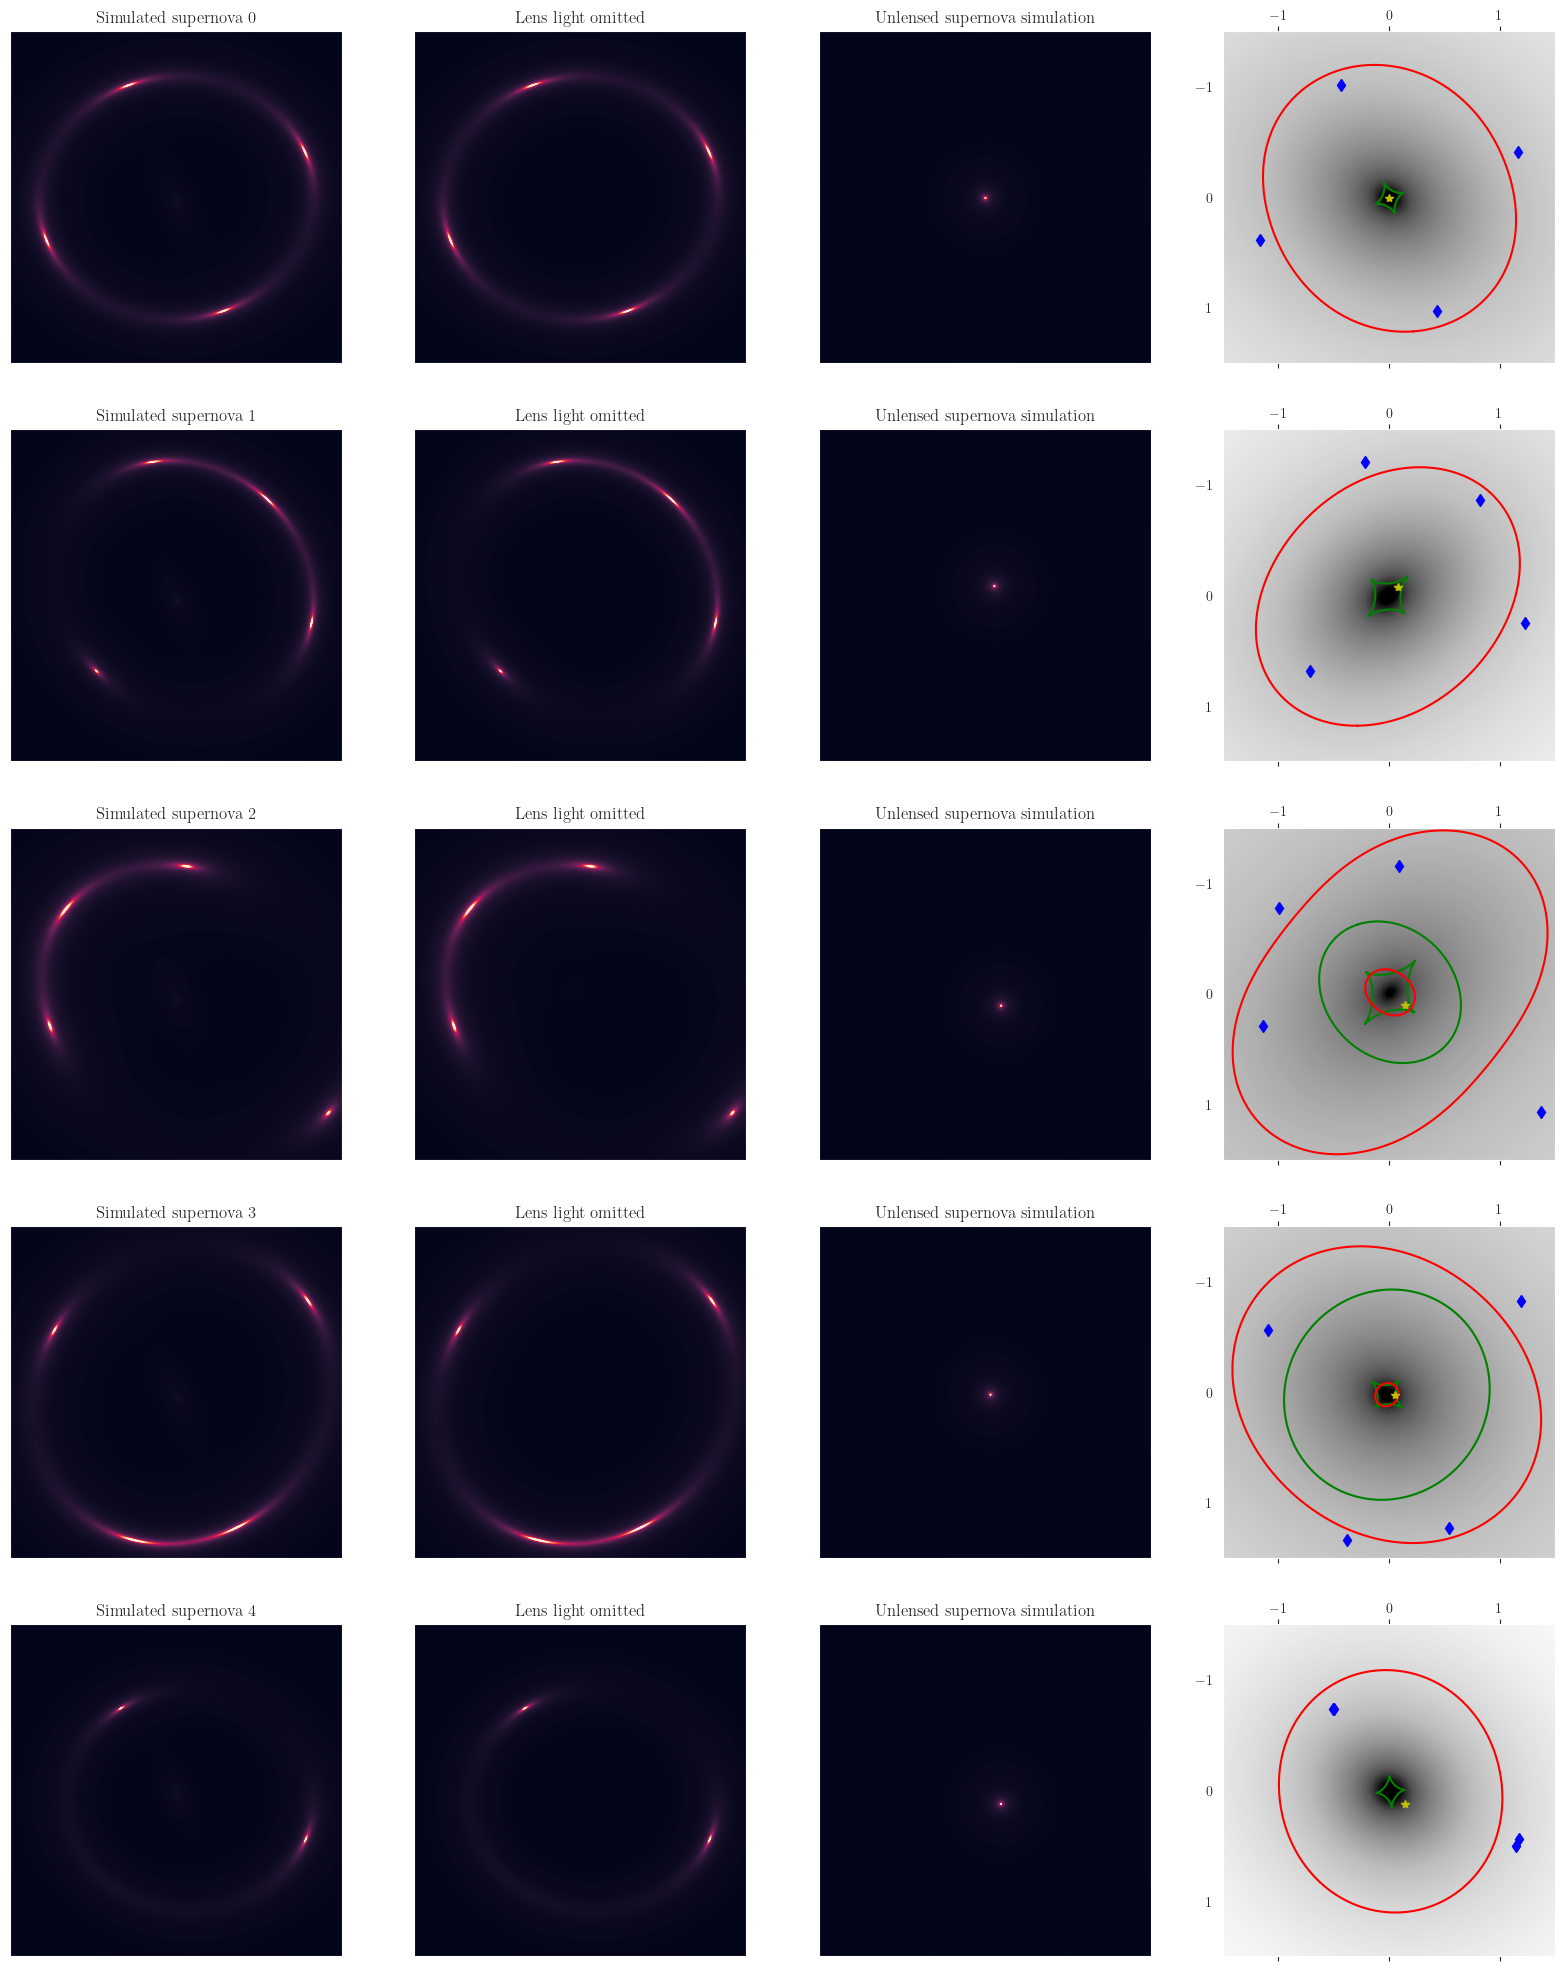

In [ ]:
lensed_images = []
fig, axes = plt.subplots(num_systems, 4, figsize = (20, 5*num_systems))
lens_model_list = ['EPL', 'SHEAR']
lensModel = LensModel(lens_model_list=lens_model_list)

for i in range(num_systems):
  truth = [
      systems[i], #Mass model
      [
          {'R_sersic': 0.350, 'n_sersic': 2.586, 'e1': -0.262, 'e2': 0.239, 'center_x': 0.011, 'center_y': 0.048, 'Ie': 35.055}
       ], # Lens Light
      source_truth[i],
      ]

  sim_img = lens_sim.simulate(truth)
  lens_omitted_img= lens_sim.simulate([truth[0],[],truth[2]]) # Omit lens light
  source_img = lens_sim.simulate([[],[],truth[2]]) # Source
  lensed_images.append(lens_omitted_img)
  fig0 = axes[i,0].imshow(sim_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=8),)
  axes[i,0].set_title(f'Simulated supernova {i}')
  fig1 = axes[i,1].imshow(lens_omitted_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=8),)
  axes[i,1].set_title('Lens light omitted') #The same in cases as SNZWICKY
  fig2 = axes[i,2].imshow(source_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=8),)
  axes[i,2].set_title('Unlensed supernova simulation')

  kwargs_spep = truth[0][0]
  kwargs_shear = truth[0][1]
  kwargs_lens = [kwargs_spep, kwargs_shear]

  sourcePos_x = truth[2][0]['center_x']
  sourcePos_y = truth[2][0]['center_y']

  converter = BrightestPoints(number_of_images = 4, num_pixels=num_pix, grid_size=num_pix/3, delta_pix=delta_pix, supersample=1)
  brightest_pixels = converter.find_brightest_points(lensed_images[i])
  x_arcsec, y_arcsec = converter.pix_to_arcsec(brightest_pixels)

  lens_plot.lens_model_plot(axes[i,3], lensModel=lensModel,
                            kwargs_lens=kwargs_lens,numPix=num_pix, deltaPix=delta_pix,
                            sourcePos_x=sourcePos_x, sourcePos_y=sourcePos_y, point_source=False,
                            with_caustics=True, fast_caustic=True,

                            coord_inverse=False)
  axes[i,3].plot(x_arcsec,y_arcsec,'bd')
  axes[i,3].plot(sourcePos_x,sourcePos_y,'y*')

  axes[i,3].invert_yaxis()


  # cax = plt.axes([0.95, 0.3, 0.02, 0.2])  # [left, bottom, width, height]
  # colorbar = fig.colorbar(fig0, ax = axes, cax = cax, extend = 'max',)#anchor = (-0.3,0.5))
  # colorbar.outline.set_edgecolor('grey')
  # colorbar.outline.set_linewidth(0.5)


plt.setp(axes[:,:3], xticks=[], yticks=[])
plt.show()

In [ ]:
# plt.imshow(sim_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=1000))
# colorbar = plt.colorbar(extend = 'max',anchor = (-0.3,0.5))
# colorbar.outline.set_edgecolor('grey')
# colorbar.outline.set_linewidth(0.5)
# plt.axis('off')


# plt.show()

# Determine the brightest points

In [ ]:
# truth = [
#       values2[0], #Mass model
#       [
#           {'R_sersic': 0.350, 'n_sersic': 2.586, 'e1': -0.262, 'e2': 0.239, 'center_x': 0.011, 'center_y': 0.048, 'Ie': 35.055}
#        ], # Lens Light
#       source_truth[index]# Source Light
#       ]

In [ ]:
# value_image = lens_sim.simulate(truth)

In [ ]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots import lens_plot
from lenstronomy.Data.imaging_data import ImageData

tf.Tensor([-0.42999998  0.43000007 -1.17        1.1660001 ], shape=(4,), dtype=float32)
tf.Tensor([-1.01        1.0300001   0.39000008 -0.406     ], shape=(4,), dtype=float32)


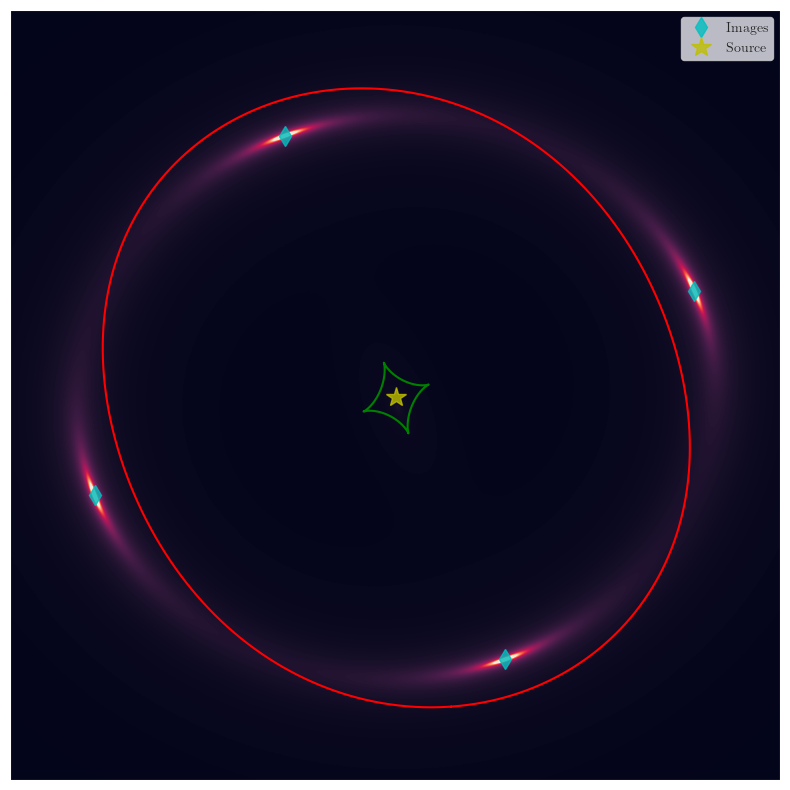

In [ ]:
index = 0 #What system to analyze. It starts at 0.

truth = [
      systems[index], #Mass model
      [
          {'R_sersic': 0.350, 'n_sersic': 2.586, 'e1': -0.262, 'e2': 0.239, 'center_x': 0.011, 'center_y': 0.048, 'Ie': 35.055}
       ], # Lens Light
      source_truth[index]# Source Light
      ]

kwargs_spep = truth[0][0]
kwargs_shear = truth[0][1]
kwargs_lens = [kwargs_spep, kwargs_shear]

sourcePos_x = truth[2][0]['center_x']
sourcePos_y = truth[2][0]['center_y']



# delta_pix = 0.0006
# num_pix = 5000

sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample,
                             # kernel = kernel,
                            ) #Delta pix set in 0.02 instead of 0.065

lens_sim = LensSimulator(phys_model, sim_config, bs=1)

sim_img_trial = lens_sim.simulate(truth)


converter = BrightestPoints(number_of_images = 4, num_pixels=num_pix, grid_size=num_pix/2, delta_pix=delta_pix, supersample=1)
brightest_pixels = converter.find_brightest_points(sim_img_trial)
x_arcsec, y_arcsec = converter.pix_to_arcsec(brightest_pixels)

print(x_arcsec)
print(y_arcsec)


extent = (-num_pix/2*delta_pix, num_pix/2*delta_pix, num_pix/2*delta_pix, -num_pix/2*delta_pix)
fig,ax = plt.subplots(1,1,figsize = (10,8))
plt.imshow(sim_img_trial, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=8),extent=extent,)

kwargs_caustics = {
        "color_crit": (0,0,0,0),
          "color_caustic": 'green'}

kwargs_criticals = {
          "color_crit": 'r',
          "color_caustic": (0,0,0,0)}

kwargs_both = {
        "color_crit": 'red',
          "color_caustic": 'green'}


lens_plot.lens_model_plot(
ax,
lensModel,
kwargs_lens,
numPix=num_pix,
deltaPix=delta_pix,
point_source=False,
with_caustics=True,
with_convergence=False,
coord_inverse=False,
fast_caustic=True,
kwargs_caustics = kwargs_both,
)

plt.plot(x_arcsec,y_arcsec,'cd', ms = 10, alpha = 0.8, label = 'Images')
plt.plot(sourcePos_x,sourcePos_y,'y*', ms = 15, alpha = 0.8, label = 'Source')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [ ]:
sns.set_style('white')

<ipython-input-37-bc2d2dbec814>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b*" (-> color='b'). The keyword argument will take precedence.
  plt.plot(center_x_truth, center_y_truth, 'b*', label = 'Source Truth Position', color = 'black')


Relative errors of x estimation after delens (%): [ 1.0853516  1.8851947 11.448759   4.6508503]
Relative errors of y estimation after delens (%): [3.9530714 4.4842978 1.7857801 5.108822 ]


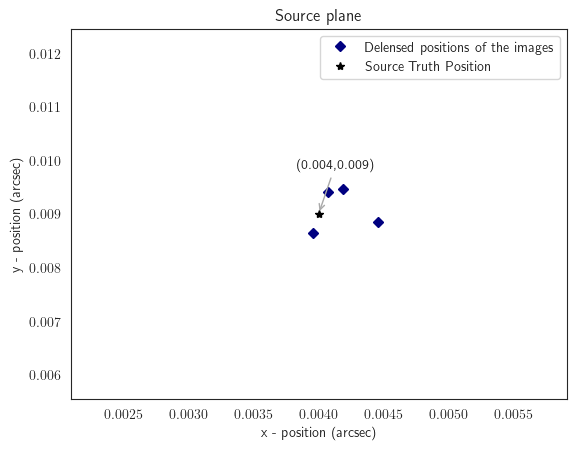

In [ ]:
#Delensing
delensed_positions = _beta_EPL_shear(x_arcsec, y_arcsec, truth)
plt.plot(delensed_positions[0], delensed_positions[1], marker = 'D',markersize = 5,linestyle = '', color = 'navy', label = 'Delensed positions of the images')
plt.title('Source plane')
plt.xlabel('x - position (arcsec)')
plt.ylabel('y - position (arcsec)')

center_x_truth, center_y_truth = truth[2][0]['center_x'], truth[2][0]['center_y']
plt.plot(center_x_truth, center_y_truth, 'b*', label = 'Source Truth Position', color = 'black')

#Relative errors
error_x = np.abs(np.array(delensed_positions[0]) - center_x_truth)*100/center_x_truth
error_y = np.abs(np.array(delensed_positions[1]) - center_y_truth)*100/center_y_truth
print('Relative errors of x estimation after delens (%):',error_x)
print('Relative errors of y estimation after delens (%):',error_y)



plt.xlim(center_x_truth*(1 - 0.1*np.mean(error_x)), center_x_truth*(1 + 0.1*np.mean(error_x)))
plt.ylim(center_y_truth*(1 - 0.1*np.mean(error_y)), center_y_truth*(1 + 0.1*np.mean(error_y)))
plt.annotate(
   '(' + str(np.round(center_x_truth,4)) + ','+ str(np.round(center_y_truth,4)) + ')',
   xy=(center_x_truth,center_y_truth),
   xytext=(40, 30),
   textcoords='offset points', ha='right', va='bottom',
  #  bbox=dict(boxstyle='round,pad=0.5', fc='darkgrey'),
   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color = 'darkgrey', )
   )

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Eccentricities: e1 and e2 approach

## Loss function

In [ ]:
# start = prob_model.prior.sample(2)
# trial = tf.Variable(prob_model.bij.inverse(start))

# print(prob_model.bij.forward(trial))

### **Time Delay** + Flux + Distance Information

In [ ]:
# init_amp = 15.0 #SNZWicky
# init_amp = 1.0

# weight_dist = 3.*1e3 #Seems good
weight_dist = 5.*1e3
# weight_dist = 3.*1e4
# weight_dist = 8.*1e3

weight_flux = 5.*1e9 #Seems good
# weight_flux = 5.*1e7
# weight_flux = 5.*1e5
# weight_flux = 1.*1e10

weight_fermatPot = 3.*1e3 #Seems good in order of days
# weight_fermatPot = 0.0
# weight_fermatPot = 5.*1e4
# weight_fermatPot = 1.*1e4




def point_loss(params, test = False):
    # params is in unconstrained space
    const_param = prob_model.bij.forward(params) #Constrained space


    #MINIMIZE COMPACTNESS OF SOURCE PLANE
    tens_param = tf.convert_to_tensor(_beta_EPL_shear(x, y, const_param))
    source_param = tf.math.reduce_mean(tens_param, axis = 1)
    sourcePos_x_param, sourcePos_y_param = source_param[0], source_param[1]
    shifted_tens_param = tf.concat([tens_param[:,-1:,:], tens_param[:,:-1,:]], axis=1)
    # dist_loss = ((tens[0, 0, :] - tens[0, 1, :])**2+(tens[1, 0, :] - tens[1, 1, :])**2)**0.5 + ((tens[0, 0, :] - tens[0, 2, :])**2+(tens[1, 0, :] - tens[1, 2, :])**2)**0.5 + ((tens[0, 0, :] - tens[0, 3, :])**2+(tens[1, 0, :] - tens[1, 3, :])**2)**0.5
    dist_loss = tf.math.reduce_mean(tf.math.reduce_sum((tens_param - shifted_tens_param)**2, axis = 0)**0.5, axis = 0)


    #MINIMIZE FLUX DIFFERENCE
    mag_param = magnification(x,y,const_param)
    init_amp = const_param[0][2]['amp']
    flux_param = mag_param**2/init_amp**2  #Actually the inverse of flux

    flux_loss = tf.math.reduce_mean((flux_param - flux_truth)**2, axis = 0)

    #MINIMIZE fermatPot DIFFERENCE
    fermatPot_param = fermat_potential(x,y,const_param, sourcePos_x_param, sourcePos_y_param)
    fermatPot_param -= fermatPot_param[0] #Relative fermatPot #x and y must be sorted such that x[0] is the earliest to arrive

    fermatPot_loss = tf.math.reduce_mean((fermatPot_param - fermatPot_truth)**2, axis = 0)

    if test:
      return - dist_loss*weight_dist, - flux_loss*weight_flux, - fermatPot_loss*weight_fermatPot, prior.log_prob(const_param),prob_model.unconstraining_bij.forward_log_det_jacobian(prob_model.pack_bij.forward(params))
    else:
      return - dist_loss*weight_dist - flux_loss*weight_flux - fermatPot_loss*weight_fermatPot + prior.log_prob(const_param)+prob_model.unconstraining_bij.forward_log_det_jacobian(prob_model.pack_bij.forward(params))

## Modeling

### Initialization

#### Set prior

In [ ]:
from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic
from gigalens.tf.profiles.mass import sis, shear, epl, sie

In [ ]:
from tensorflow_probability import distributions as tfd, bijectors as tfb

lens_prior = tfd.JointDistributionSequential( #UNIFORM PRIOR
  [tfd.JointDistributionNamed(
      dict(
          # theta_E=tfd.Uniform(low = 0.0, high = 0.3),
          # theta_E=tfd.Uniform(low = 0.8, high = 1.5),
          theta_E=tfd.Uniform(low = 0.5, high = 2.0),
          #  gamma=tfd.Uniform(1.99, 2.01,),
          #  gamma=tfd.Uniform(1.8, 2.3,),
          #  gamma=tfd.Uniform(1.3, 2.8,),
          # gamma=tfd.Normal(2, 0.25),
          # gamma=tfd.TruncatedNormal(2, 0.25, 1.5, 2.5),
          gamma=tfd.TruncatedNormal(2.0, 0.25, 1.5, 2.5),
          #  e1=tfd.Uniform(-0.1, 0.1),
          #  e2=tfd.Uniform(-0.1, 0.1),
          #  e1=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          #  e2=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          e1=tfd.Normal(0, 0.1),
          e2=tfd.Normal(0, 0.1),
          #  e1=tfd.Uniform(-0.2, 0.2),
          #  e2=tfd.Uniform(-0.2, 0.2),
          center_x=tfd.Normal(0, 0.1),
          center_y=tfd.Normal(0, 0.1),
          #  center_x=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          #  center_y=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          #  center_x=tfd.Uniform(-0.1, 0.1),
          #  center_y=tfd.Uniform(-0.1, 0.1),
          )
      ),
   tfd.JointDistributionNamed(
       dict(
          #  gamma1=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
          #  gamma2=tfd.TruncatedNormal(0, 0.1, -0.2, 0.2),
           gamma1=tfd.Normal(0, 0.1),
           gamma2=tfd.Normal(0, 0.1),
          # gamma1=tfd.Uniform(-0.1, 0.1),
          # gamma2=tfd.Uniform(-0.1, 0.1),
          ),
       ),
   tfd.JointDistributionNamed( ####TYPE IA SNe HAVE UNC ~0.1-0.2 MAGNITUDES, WHICH CORRESPONDS TO 10-20% BRIGHTNESS UNC
       dict(
           # amp=tfd.Normal(1, 0.1*1), #(10% sigma)
           amp=tfd.Normal(15, 0.1*15), #SNZwicky (10% sigma)
           # amp = tfd.Uniform(15 - 0.2*15,15 + 0.2*15), #SNZwicky (20% interval)
          ),
       ),
  ]
  )


prior = tfd.JointDistributionSequential(
    [lens_prior,]
)


prob_model = ForwardProbModel(prior, sim_img, background_rms=0.2, exp_time=100)

example = lens_prior.sample(seed = 0)
size = int(tf.size(tf.nest.flatten(example)))

#### Format brightest points and use measurements

In [ ]:
##Redshift information

from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

z_lens, z_source = 0.2262, 0.3544 #Fill in your redshifts

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

lensCosmo = LensCosmo(
        z_lens=z_lens, z_source=z_source, cosmo=cosmo
    )

In [ ]:
use_measurements = False

if use_measurements:
    #Plug in your measurements

    # SNZWicky
    x_arcsec_measured = tf.constant([0.05, -0.14999999, 0.17, -0.06999999],dtype = tf.float32) #SNZWicky
    y_arcsec_measured = tf.constant([-0.14999999, -0.10999999, 0.03, 0.13],dtype = tf.float32) #SNZWicky
    flux_measured = tf.constant([76.36,39.47,36.90,86.96]) #SNZWicky    ORIGINAL
    # flux_measured = tf.constant([90.00,39.47,36.90,86.96]) #SNZWicky    PROVISIONAL SIMULATION
    # time_delay_measured = tf.constant([0.438, 0.525, 0.538, 0.]) #SNZWicky
    ##### Don't use TD info for SNZWicky (weight_fermat_pot = 0.)
    time_delay_measured = tf.constant([1e-8,2e-8,3e-8,0.]) #Set like this to preserve the order wrt to image A

    ## Index 10 of 'systems'
    # x_arcsec_measured = tf.constant([0.9125001, -0.93749994, 2.3125, -2.3125],dtype = tf.float32) #Index 10 of the true systems
    # y_arcsec_measured = tf.constant([2.3625002, -2.3374999, -0.8874999, 0.9125001],dtype = tf.float32) #Index 10 of the true systems
    # flux_measured = tf.constant([75.782,75.467,55.921,55.644])*1.5  #Index 10 of the true systems
    # time_delay_measured = tf.constant([0.0, 0.088, 44.809, 45.114]) #Index 10 of the true systems

    ## Made up measurements (tough to make sensible measurements)
    # x_arcsec_measured = tf.constant([-1.36, -1.114, 0.95, 1.30],dtype = tf.float32)
    # y_arcsec_measured = tf.constant([1.12, -1.32, 0.96, -1.06],dtype = tf.float32)
    # flux_measured = tf.constant([23.45,45.67,82.4,45.6])
    # time_delay_measured = tf.constant([0.0, 2.4, 10.34, 32.3])

    # ## SN iPTF16geu
    # r_measured = tf.constant([0.251,0.324,0.297,0.276])
    # phi_measured = tf.constant([4.468,2.679,1.013,5.860])
    # x_arcsec_measured = r_measured*tf.math.cos(phi_measured)
    # y_arcsec_measured = r_measured*tf.math.sin(phi_measured)
    # # x_arcsec_measured = tf.constant([-0.060733, -0.289947, 0.1572, 0.251653],dtype = tf.float32)
    # # y_arcsec_measured = tf.constant([-0.24354, 0.14459, 0.252, -0.113344],dtype = tf.float32)
    # flux_measured = tf.constant([35.6,15.7,7.5,9.1])
    # time_delay_measured = tf.constant([1.43, 1.2, 0.0, 2.79])


    sort_order = tf.argsort(time_delay_measured,-1)
    time_delay_measured = tf.gather(time_delay_measured, sort_order)
    flux_measured = tf.gather(flux_measured, sort_order)
    x_arcsec_measured = tf.gather(x_arcsec_measured, sort_order)
    y_arcsec_measured = tf.gather(y_arcsec_measured, sort_order)

    chains = 1
    x = tf.repeat(x_arcsec_measured[..., tf.newaxis], [chains], axis=-1)
    y = tf.repeat(y_arcsec_measured[..., tf.newaxis], [chains], axis=-1)

    fermatPot_measured = lensCosmo.time_delay2fermat_pot(time_delay_measured) #From TD to FP
    print('Time delay measured', time_delay_measured)

else:
    #Sorting the brightest points as the order of later arrival
    delens_sorting = _beta_EPL_shear(x_arcsec, y_arcsec, truth)
    sourcePos_x_truth_sorting = tf.math.reduce_mean(delens_sorting[0])
    sourcePos_y_truth_sorting = tf.math.reduce_mean(delens_sorting[1])

    fermatPot_sorting = fermat_potential(x_arcsec, y_arcsec, truth, sourcePos_x_truth_sorting, sourcePos_y_truth_sorting)

    sort_order = tf.argsort(fermatPot_sorting,-1)
    x_arcsec_sorted = tf.gather(x_arcsec, sort_order)
    y_arcsec_sorted = tf.gather(y_arcsec, sort_order)

    #Check it is sorted
    fermatPot_sorted = fermat_potential(x_arcsec_sorted, y_arcsec_sorted, truth, sourcePos_x_truth_sorting, sourcePos_y_truth_sorting)
    fermatPot_sorted -= fermatPot_sorted[0]


    #Use x and y ordered as the time delay

    chains = 1
    x = tf.repeat(x_arcsec_sorted[..., tf.newaxis], [chains], axis=-1)
    y = tf.repeat(y_arcsec_sorted[..., tf.newaxis], [chains], axis=-1)
    print(x,y)

    sim_time_delay_sorted = lensCosmo.time_delay_units(fermatPot_sorted, kappa_ext = 0) #Convert fermatPot (arcsec^2) to time delay (days)
    print('Time delay simulated and sorted', sim_time_delay_sorted)

    # lensCosmo.time_delay2fermat_pot(TD) #From TD to FP

    print('True init amp =', truth[0][2]['amp'])


tf.Tensor(
[[ 1.1660001 ]
 [-1.17      ]
 [-0.42999998]
 [ 0.43000007]], shape=(4, 1), dtype=float32) tf.Tensor(
[[-0.406     ]
 [ 0.39000008]
 [-1.01      ]
 [ 1.0300001 ]], shape=(4, 1), dtype=float32)
Time delay simulated and sorted tf.Tensor([0.         0.11413524 6.0854836  6.518546  ], shape=(4,), dtype=float32)
True init amp = 15


In [ ]:
if use_measurements:
    #INPUT MEASUREMENTS
    print('USING MEASUREMENTS')
    flux_truth = 1/tf.constant(flux_measured, dtype = tf.float32)**2
    flux_truth = tf.repeat(flux_truth[..., tf.newaxis], [chains], axis=-1)

    fermatPot_truth = tf.constant(fermatPot_measured, dtype = tf.float32) #Already relative to the minimum as measured
    fermatPot_truth = tf.repeat(fermatPot_truth[..., tf.newaxis], [chains], axis=-1)

else:
    #SIMULATE TRUE SOURCE
    delens_truth = _beta_EPL_shear(x, y, truth)
    tens_truth = tf.convert_to_tensor(delens_truth)
    source_pos_truth = tf.math.reduce_mean(tens_truth, axis = 1)
    sourcePos_x_truth = source_pos_truth[0]
    sourcePos_y_truth = source_pos_truth[1]
    #SIMULATE TRUE FLUX
    mag_truth = magnification(x,y,truth)
    init_amp = truth[0][2]['amp']
    flux_truth = mag_truth**2/init_amp**2  #Actually the inverse of flux squared

    #SIMULATE TRUE FERMAT POTENTIAL
    fermatPot_truth = fermat_potential(x,y,truth, sourcePos_x_truth, sourcePos_y_truth)
    fermatPot_truth -= fermatPot_truth[0] #Measured fermat pot (Obtained by measuring time delay and changing units)
    print('True flux', 1/tf.math.sqrt(flux_truth))

True flux tf.Tensor(
[[127.64432]
 [129.72679]
 [124.09568]
 [117.8832 ]], shape=(4, 1), dtype=float32)


### MAP

In [ ]:
# n_map = 500 #Original
n_map = 1000
n_steps = 400
# schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-2, 300, 1e-2/5) #Original
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-1, n_steps, 1e-2/5)
optimizer = tf.keras.optimizers.Adam(schedule_fn)


start_modeling = time.time()


# MAP_sample = MAP(optimizer=optimizer, n_samples=n_map, num_steps=300, seed=0) #Original
MAP_sample = MAP(optimizer=optimizer, n_samples=n_map, num_steps=n_steps, seed=0)


end = time.time()

elapsed = end-start_modeling

print('MAP takes ',timedelta(seconds=elapsed))

In [ ]:
lps = point_loss(MAP_sample)
best = MAP_sample[tf.argmax(lps)]

In [ ]:
print(truth[0])

In [ ]:
prob_model.bij.forward([best])

In [ ]:
point_loss([best], test = True)

Plot graphs for the obtained MAP - truth.

In [ ]:
if use_measurements:
    delens_modeled_MAP = _beta_EPL_shear(x_arcsec_measured, y_arcsec_measured, [prob_model.bij.forward([best])[0],[],[]])
    tens_modeled_MAP = tf.convert_to_tensor(delens_modeled_MAP)
    source_modeled_MAP = tf.math.reduce_mean(tens_modeled_MAP, axis = 1)
    sourcePos_x_modeled_MAP = source_modeled_MAP[0].numpy()
    sourcePos_y_modeled_MAP = source_modeled_MAP[1].numpy()
    modeled_truth_MAP = [
      prob_model.bij.forward([best])[0], #Mass model
      [

       ], # Lens Light
             [
        {'center_x': sourcePos_x_modeled_MAP, 'center_y': sourcePos_y_modeled_MAP, 'Ie': 2*281.973},
    ],
      ]

    plt.plot(x_arcsec_measured,y_arcsec_measured,'cd', ms = 15, alpha = 0.8, label = 'True positions')

else:

    modeled_truth_MAP = [
      prob_model.bij.forward([best])[0], #Mass model
      [

       ], # Lens Light
      source_truth[index]# Source Light
      ]
    delens_modeled_MAP = _beta_EPL_shear(x_arcsec_sorted, y_arcsec_sorted, modeled_truth_MAP)
    sourcePos_x_modeled_MAP = tf.math.reduce_mean(delens_modeled_MAP[0])
    sourcePos_y_modeled_MAP = tf.math.reduce_mean(delens_modeled_MAP[1])

modeled_img_MAP = lens_sim.simulate(modeled_truth_MAP)

extent = (-num_pix/2*delta_pix, num_pix/2*delta_pix, num_pix/2*delta_pix, -num_pix/2*delta_pix)
plt.imshow(modeled_img_MAP, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=8),extent=extent,)
plt.grid(False)
plt.gca().invert_yaxis()
# plt.xticks([])
# plt.yticks([])
plt.tight_layout()
plt.title('Modeled image MAP')
plt.show()

### SVI

In [ ]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 500, 4e-2, 1.0) #Original
# schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 500, 4e-3, 1)
# schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(4e-7, 500, 4e-5, 1.0)
optimizer = tf.keras.optimizers.Adam(schedule_fn)


start = time.time()


# q_z, losses = SVI(optimizer=optimizer, start=best, n_vi=500, num_steps=600) #Original
q_z, losses = SVI(optimizer=optimizer, start=best, n_vi=500, num_steps=600)
plt.plot(losses)


end = time.time()

elapsed = end-start

print('SVI takes ',timedelta(seconds=elapsed))

In [ ]:
truth[0]

In [ ]:
prob_model.bij.forward([q_z.mean()])

### HMC

In [ ]:
import pickle

start = time.time()

# samples, sample_stats = HMC(q_z=q_z, n_hmc=50, init_eps=0.5, init_l=3, max_leapfrog_steps=100,
#                                    num_burnin_steps=250, num_results = 750) #Original
samples, sample_stats = HMC(q_z=q_z, n_hmc=50, init_eps=0.5, init_l=3, max_leapfrog_steps=100,
                                    num_burnin_steps=250, num_results = 750)
# samples, sample_stats = HMC(q_z=q_z, n_hmc=50, init_eps=0.5, init_l=3, max_leapfrog_steps=30,
#                                    num_burnin_steps=100, num_results = 750)

end_modeling = time.time()

elapsed = end_modeling-start

elapsed_modeling = end_modeling - start_modeling

print('HMC takes ',elapsed, 'seconds')

HMC takes  11028.241485834122 seconds


#### Chains

In [ ]:
get_samples = lambda x: tf.convert_to_tensor([
    x[0][0]['theta_E'],
    x[0][0]['gamma'],
    x[0][0]['e1'],
    x[0][0]['e2'],
    x[0][0]['center_x'],
    x[0][0]['center_y'],
    x[0][1]['gamma1'],
    x[0][1]['gamma2'],
    x[0][2]['amp'],
])


physical_samples = get_samples(prob_model.bij.forward(samples)).numpy()

from scipy.stats import norm

# colors = ['#1f0a1d','limegreen','seagreen','navy','darkkhaki']

colors = [
    '#1f0a1d',   # Dark reddish-purple
    '#8b4513',   # Saddle brown
    '#b22222',    # Firebrick
    '#4b0082',   # Indigo
    '#800000',   # Maroon
    '#6a5acd',   # Slate blue
    '#2e8b57',   # Sea green
    '#006400',   # Dark green
    '#556b2f',   # Dark olive green
    'navy',      # Dark blue
]




fig = plt.figure(figsize=(10, 3))
gs = plt.GridSpec(1, 2, width_ratios=[1, .4], height_ratios=[1])
ax1 = plt.subplot(gs[0, 0],)

ax1.grid(True)


start_chain = 0
num_chains = 10
for i in range(start_chain,start_chain+num_chains):
  ax1.plot(physical_samples[0,:,i],
          colors[i-start_chain],
          # label = f'{i}',
           alpha = 0.6)
  plt.title('HMC $\\theta_E$')
  plt.xlabel('Iterations')
#  plt.legend(title = 'Chains', loc = 'center left', bbox_to_anchor=(1.1, 0.5))

ax2 = plt.subplot(gs[0, 1], sharey=ax1)


for i in range(start_chain,start_chain+num_chains):
  prob, bins = np.histogram(physical_samples[0,:,i], density = True, bins = 40)
  (mu, sigma) = norm.fit(physical_samples[0,:,i])

  pdf = norm.pdf(bins, mu, sigma)
  ax2.plot(pdf, bins,
           colors[i-start_chain],
           linewidth=2, alpha = 0.8)

ax2.grid(True)
plt.gca().axes.get_xaxis().set_visible(False)
plt.tick_params(axis='y', labelsize=0)
plt.gca().axes.get_yaxis().set_visible(True)
plt.tight_layout()
plt.show()


# fig.savefig('/content/drive/My Drive/Point_source/images/chains-theta_E'+ date + '.svg', format = 'svg') #Saul's drive





fig = plt.figure(figsize=(10, 3))
gs = plt.GridSpec(1, 2, width_ratios=[1, .4], height_ratios=[1])
ax1 = plt.subplot(gs[0, 0],)

ax1.grid(True)



for i in range(start_chain,start_chain+num_chains):
  ax1.plot(physical_samples[1,:,i],
          colors[i-start_chain],
          # label = f'{i}',
           alpha = 0.6)
  plt.title('HMC $\\gamma$')
  plt.xlabel('Iterations')
#  plt.legend(title = 'Chains', loc = 'center left', bbox_to_anchor=(1.1, 0.5))

ax2 = plt.subplot(gs[0, 1], sharey=ax1)


for i in range(start_chain,start_chain+num_chains):
  prob, bins = np.histogram(physical_samples[1,:,i], density = True, bins = 40)
  (mu, sigma) = norm.fit(physical_samples[1,:,i])

  pdf = norm.pdf(bins, mu, sigma)
  ax2.plot(pdf, bins,
           colors[i-start_chain],
           linewidth=2, alpha = 0.8)

ax2.grid(True)
plt.gca().axes.get_xaxis().set_visible(False)
plt.tick_params(axis='y', labelsize=0)
plt.gca().axes.get_yaxis().set_visible(True)
plt.tight_layout()
plt.show()

# fig.savefig('/content/drive/My Drive/Point_source/images/chains-gamma'+ date + '.svg', format = 'svg') #Saul's drive

NameError: name 'prob_model' is not defined

#### Cornerplot and Rhats

Rhats are:
 [{'theta_E': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0377556], dtype=float32)>, 'gamma': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0631785], dtype=float32)>, 'e2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0457393], dtype=float32)>, 'e1': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0757551], dtype=float32)>, 'center_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0138825], dtype=float32)>, 'center_x': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0018018], dtype=float32)>}, {'gamma2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.037707], dtype=float32)>, 'gamma1': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0653021], dtype=float32)>}, {'amp': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0373625], dtype=float32)>}]
The maximum Rhat is 1.0757551
The second maximum Rhat is 1.0653021
ESS are:
 [{'theta_E': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([657.9297], dtype=float32)>, 

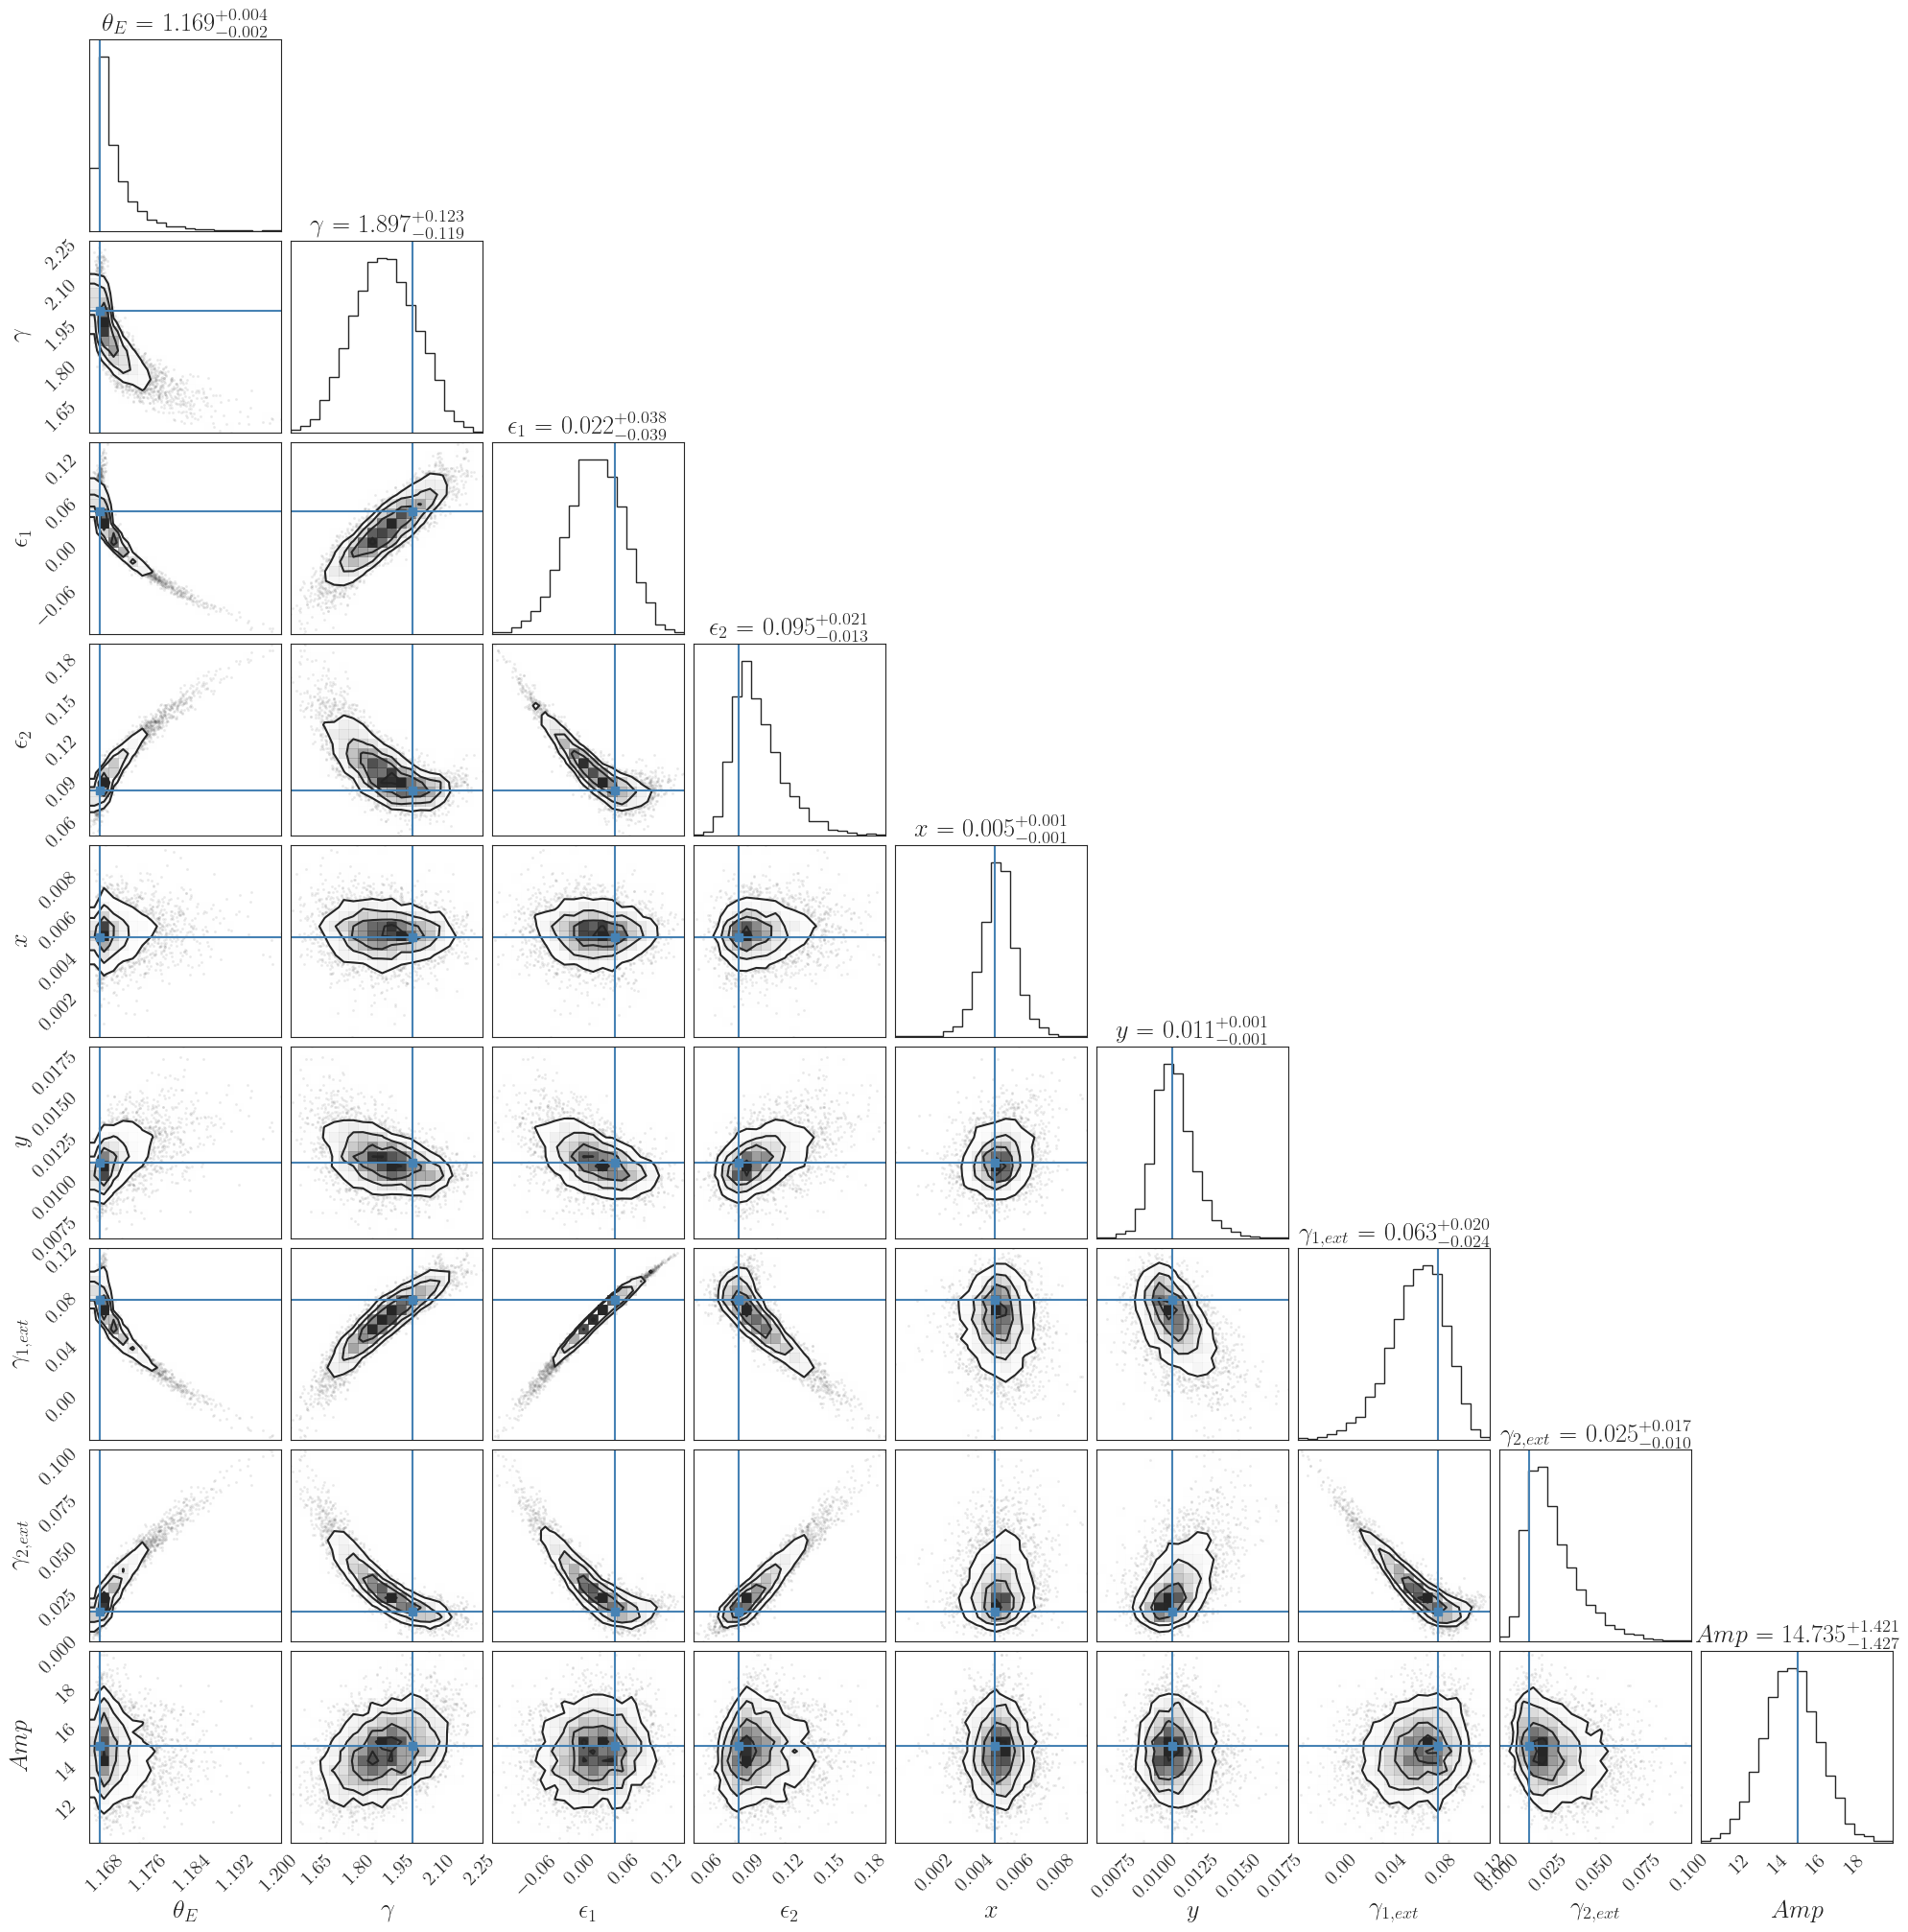

In [ ]:
Rhat = tfp.mcmc.potential_scale_reduction(samples).numpy()
# ESS = tfp.mcmc.effective_sample_size(samples, cross_chain_dims=1).numpy() #sometimes gives: warning complex64 input
ESS = np.sum(tfp.mcmc.effective_sample_size(samples, cross_chain_dims=None).numpy(), axis = 0)
print('Rhats are:\n',prob_model.pack_bij.forward([Rhat])[0])
print('The maximum Rhat is',np.max(Rhat))

Rhat2 = Rhat
max_value = np.max(Rhat2)
Rhat2[np.where(Rhat2 == max_value)] = -np.inf
second_max = np.max(Rhat2)

print('The second maximum Rhat is',np.max(Rhat2))

print('ESS are:\n', prob_model.pack_bij.forward([ESS])[0])
print('The truth is:\n',truth[0])

markers = get_samples(truth)
if use_measurements:
    mass_corner_fig = corner(physical_samples.reshape((9,-1)).T,
           show_titles=True, title_fmt='.3f',
           labels=[
               r'$\theta_E$', r'$\gamma$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x$', r'$y$', r'$\gamma_{1,ext}$', r'$\gamma_{2,ext}$', r'$Amp$'
           ],
              label_kwargs = {'fontsize': 19}, title_kwargs = {'fontsize': 19},);
else:
    mass_corner_fig = corner(physical_samples.reshape((9,-1)).T, truths = markers,
           show_titles=True, title_fmt='.3f',
           labels=[
               r'$\theta_E$', r'$\gamma$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x$', r'$y$', r'$\gamma_{1,ext}$', r'$\gamma_{2,ext}$', r'$Amp$'
           ],
             label_kwargs = {'fontsize': 19}, title_kwargs = {'fontsize': 19},);


axes = mass_corner_fig.get_axes()

# Set the fontsize of the ticks
fontsize = 15  # Adjust the fontsize as per your preference
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

plt.show()



# mass_corner_fig.savefig('/content/drive/My Drive/Point_source/images/corner'+ date + '.svg', format = 'svg') #Saul's drive


In [ ]:
best_HMC = prob_model.pack_bij.forward([np.median(prob_model.pack_bij.inverse(prob_model.bij.forward(samples)).numpy().reshape(-1,9), axis = 0)])

#### Predictions

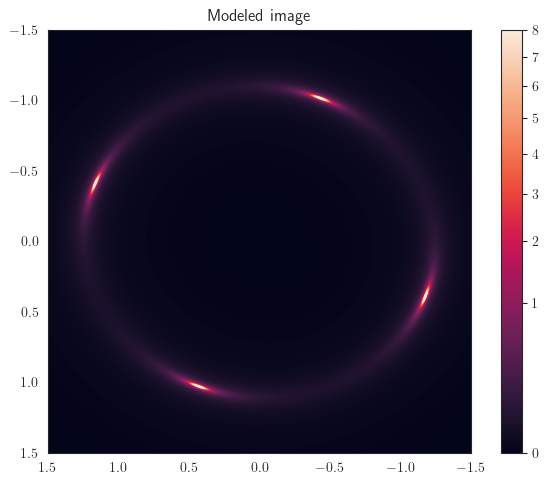

In [ ]:
if use_measurements:
    delens_modeled = _beta_EPL_shear(x_arcsec_measured, y_arcsec_measured, [best_HMC[0],[],[]])
    tens_modeled = tf.convert_to_tensor(delens_modeled)
    source_modeled = tf.math.reduce_mean(tens_modeled, axis = 1)
    sourcePos_x_modeled = source_modeled[0].numpy()
    sourcePos_y_modeled = source_modeled[1].numpy()
    modeled_truth = [
      best_HMC[0], #Mass model
      [

       ], # Lens Light
             [
        {'center_x': sourcePos_x_modeled, 'center_y': sourcePos_y_modeled, 'Ie': 2*280.973},
    ],
      ]

else:

    modeled_truth = [
      best_HMC[0], #Mass model
      [

       ], # Lens Light
      source_truth[index]# Source Light
      ]
    delens_modeled = _beta_EPL_shear(x_arcsec_sorted, y_arcsec_sorted, modeled_truth)
    sourcePos_x_modeled = tf.math.reduce_mean(delens_modeled[0])
    sourcePos_y_modeled = tf.math.reduce_mean(delens_modeled[1])

modeled_img = lens_sim.simulate(modeled_truth)

extent = (-num_pix/2*delta_pix, num_pix/2*delta_pix, num_pix/2*delta_pix, -num_pix/2*delta_pix)
plt.imshow(modeled_img,
           norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=8),
           extent=extent,
          )
plt.colorbar()
plt.grid(False)
plt.gca().invert_xaxis()
# plt.xticks([])
# plt.yticks([])
plt.tight_layout()
plt.title('Modeled image')
plt.show()

In [ ]:
truth

[[{'theta_E': 1.167,
   'gamma': 2.0,
   'e1': 0.049,
   'e2': 0.083,
   'center_x': 0.005,
   'center_y': 0.011},
  {'gamma1': 0.078, 'gamma2': 0.015},
  {'amp': 15}],
 [{'R_sersic': 0.35,
   'n_sersic': 2.586,
   'e1': -0.262,
   'e2': 0.239,
   'center_x': 0.011,
   'center_y': 0.048,
   'Ie': 35.055}],
 [{'center_x': 0.004, 'center_y': 0.009, 'Ie': 2815.973}]]

In [ ]:
best_HMC[0]

[{'theta_E': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.1685412], dtype=float32)>,
  'gamma': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.8972411], dtype=float32)>,
  'e2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0945493], dtype=float32)>,
  'e1': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.02195373], dtype=float32)>,
  'center_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.01105664], dtype=float32)>,
  'center_x': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.00519431], dtype=float32)>},
 {'gamma2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.02478844], dtype=float32)>,
  'gamma1': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.06308419], dtype=float32)>},
 {'amp': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([14.734842], dtype=float32)>}]

In [ ]:
physical_samples_dict = prob_model.bij.forward(tf.reshape(samples,[-1,9]))
#x,y definitions depend on use_measurements = true/false (see def above)

modeled_FP_samples = fermat_potential(x,y,[physical_samples_dict[0],[],[]],sourcePos_x_modeled,sourcePos_y_modeled)
modeled_TD_samples = lensCosmo.time_delay_units(modeled_FP_samples,kappa_ext = 0)
modeled_TD_samples -= modeled_TD_samples[0]

TD_unc = np.std(modeled_TD_samples.numpy(), axis = 1)


### std(amp/detA) = amp_min/detA_min * sqrt((std(amp)/amp_min)**2 + (std(detA)/detA_min)**2)
detA_samples = magnification(x,y,[physical_samples_dict[0],[],[]])
detA_std = np.std(detA_samples.numpy(), axis = 1)
amp_samples = physical_samples_dict[0][2]['amp']
amp_std = np.std(amp_samples.numpy(),)

print('Check this uncertainty is small for Taylor Approx',detA_std, amp_std)
detA_min = (magnification(x,y,modeled_truth)).numpy().T
amp_min = modeled_truth[0][2]['amp'].numpy()[0]
flux_unc = np.abs(amp_min/detA_min * np.sqrt((amp_std/amp_min)**2 + (detA_std/detA_min)**2))[0]

print(flux_unc)

# flux_unc_C = flux_unc[1]

##The factor of amp_std is about 3 for all images. That means that for the image with uncertainty 600 (image C) is negligible
#The magnification unc is higher in this case, assuming a prior for the amplitude

### The std for the amplitude is not small and so the approximation does not seem right
### I proceed to use the std of flux directly evaluating the flux on the sampled parameters



modeled_flux_samples = physical_samples_dict[0][2]['amp']/magnification(x,y,[physical_samples_dict[0],[],[]])
flux_unc_2 = np.std(modeled_flux_samples.numpy(), axis = 1)
print(flux_unc_2)

flux_unc = (flux_unc + flux_unc_2)/2

Check this uncertainty is small for Taylor Approx [0.01384658 0.01374724 0.01490317 0.01544909] 1.4384129
[21.65547  21.483145 19.923155 19.466026]
[13.005534 13.060216 11.570401 11.124593]


In [ ]:
# modeled_flux_samples_masked = tf.where(modeled_flux_samples-modeled_truth[0][2]['amp']/magnification(x,y,[modeled_truth[0],[],[]])<3*tf.repeat(flux_unc[..., tf.newaxis], [37500], axis=-1),modeled_flux_samples,0)

# np.std(modeled_flux_samples_masked.numpy(), axis = 1)

Total Modeling time  3:05:01.460397


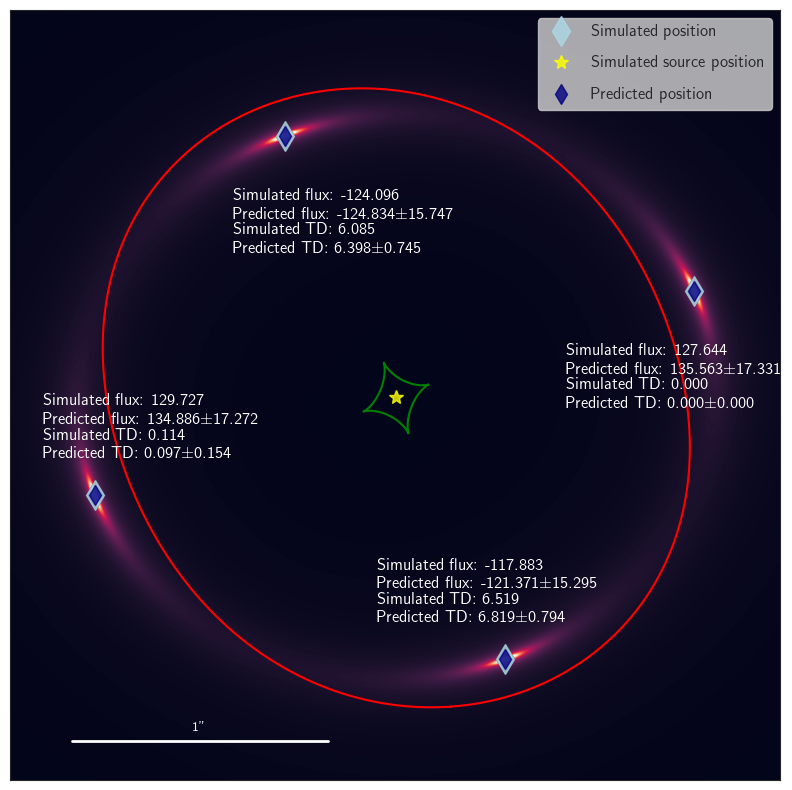

In [ ]:
print('Total Modeling time ',timedelta(seconds=elapsed_modeling))


converter = BrightestPoints(number_of_images = 4, num_pixels=num_pix, grid_size=num_pix/2, delta_pix=delta_pix, supersample=1)
brightest_pixels_modeled = converter.find_brightest_points(modeled_img)
x_arcsec_modeled, y_arcsec_modeled = converter.pix_to_arcsec(brightest_pixels_modeled)


extent = (-num_pix/2*delta_pix, num_pix/2*delta_pix, num_pix/2*delta_pix, -num_pix/2*delta_pix)
fig,ax = plt.subplots(1,1,figsize = (10,8))

lens_model_list = ['EPL', 'SHEAR']
lensModel = LensModel(lens_model_list=lens_model_list)


if use_measurements:
    best_HMC_np = np.median(physical_samples.reshape((9,-1)).T, axis = 0)
    lens_center_x = modeled_truth[0][0]['center_x']
    lens_center_y = modeled_truth[0][0]['center_y']
    angle = 0.*np.pi/180
    x_arcsec_modeled, y_arcsec_modeled = ((x_arcsec_modeled-lens_center_x)*tf.cos(angle) - (y_arcsec_modeled-lens_center_y)*tf.sin(angle) + lens_center_x,(x_arcsec_modeled-lens_center_x)*tf.sin(angle) + (y_arcsec_modeled-lens_center_y)*tf.cos(angle) + lens_center_y)
    kwargs_spep = {'theta_E': best_HMC_np[0], 'gamma': best_HMC_np[1], 'e1': best_HMC_np[2], 'e2': best_HMC_np[3], 'center_x': best_HMC_np[4], 'center_y': best_HMC_np[5]}  #Mass distribution model
    kwargs_shear = {'gamma1': best_HMC_np[6], 'gamma2': best_HMC_np[7]}
    kwargs_lens = [kwargs_spep, kwargs_shear]


    plt.imshow(modeled_img,
               norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=8),
               extent=extent,)

    lens_plot.lens_model_plot(
    ax,
    lensModel,
    kwargs_lens,
    numPix=num_pix,
    deltaPix=delta_pix,
    point_source=False,
    with_caustics=True,
    with_convergence=False,
    coord_inverse=False,
    fast_caustic=True,
    kwargs_caustics = kwargs_both,
    )

    # modeled_FP = fermat_potential(x_arcsec_measured,y_arcsec_measured,modeled_truth,sourcePos_x_modeled,sourcePos_y_modeled)
    # modeled_TD = lensCosmo.time_delay_units(modeled_FP,kappa_ext = 0)
    # modeled_TD -= modeled_TD[0]
    # modeled_flux = modeled_truth[0][2]['amp']/magnification(x_arcsec_measured,y_arcsec_measured,modeled_truth)

    modeled_FP = fermat_potential(x_arcsec_modeled,y_arcsec_modeled,modeled_truth,sourcePos_x_modeled,sourcePos_y_modeled)
    sort_order_modeled = tf.argsort(modeled_FP,-1)
    modeled_FP = tf.gather(modeled_FP, sort_order_modeled)
    modeled_TD = lensCosmo.time_delay_units(modeled_FP, kappa_ext = 0)
    modeled_TD -= modeled_TD[0]

    modeled_flux = modeled_truth[0][2]['amp']/magnification(x_arcsec_modeled,y_arcsec_modeled,modeled_truth)
    modeled_flux = tf.gather(modeled_flux, sort_order_modeled)





    for i in np.arange(len(x_arcsec_measured.numpy())):
        # annotation_str = (
        # # f"{i+1}\n"
        # f"mod_TD: {modeled_TD[i]:.3f}$\pm${TD_unc[i]:.3f}\n"
        # f"obs_TD: {time_delay_measured[i]:.3f}\n"
        # f"mod_flux: {modeled_flux[i]:.3f}$\pm${flux_unc[i]:.3f}\n"
        # f"obs_flux: {flux_measured[i]:.3f}"
        # )

        ##FORMATTING SNZWICKY
        time_delay_measured_SNZ = tf.constant([0.3,0.3,0.,0.4])
        time_delay_measured_unc_SNZ = tf.constant([2.3,2.7,0.,2.9])
        flux_measured_unc_SNZ = tf.constant([0.381069,1.82157,1.708617,1.70619]) #Ordered according to the order of arrival modeled
        flux_unc[1] = flux_unc_C  ##We use the error propagation method for this image because the sampling of the flux gives an overestimation of the error for this image whereas the amplitude std (reason why that method was rejected) is negligible in this image

        annotation_str = (
        f"Observed flux: {flux_measured[i]:.3f}$\pm${flux_measured_unc_SNZ[i]:.3f}\n"
        f"Predicted flux: {modeled_flux[i]:.3f}$\pm${flux_unc[i]:.3f}\n"
        f"Observed TD: {time_delay_measured_SNZ[i]:.3f}$\pm${time_delay_measured_unc_SNZ[i]:.3f}\n"
        f"Predicted TD: {modeled_TD[i]:.3f}$\pm${TD_unc[i]:.3f}"
        )
        ##

        plt.annotate(
        annotation_str,
        (x_arcsec_measured[i] - np.sign(x_arcsec_measured[i])*0.02 -0.06, y_arcsec_measured[i] - 0.02),
        fontsize=10,
        color='white'
        )

        letter_image = ['A','C','D','B'] #ORIGINAL
        plt.annotate(
        letter_image[i],
        # (x_arcsec_measured[i] - 0.06, y_arcsec_measured[i] - 0.02),
        (x_arcsec_measured[i]-0.01, y_arcsec_measured[i] + 0.03),
        fontsize=20,
        color='white'
        )

        plt.plot(x_arcsec_measured.numpy()[i],y_arcsec_measured.numpy()[i],'kd', ms = 15, alpha = 0.8, markerfacecolor='none')

    plt.plot(x_arcsec_measured,y_arcsec_measured,'d', ms = 15, alpha = 0.8, label = 'Observed position',color = 'lightblue')
    plt.plot(sourcePos_x_modeled,sourcePos_y_modeled,'*', ms = 10, alpha = 0.8, label = 'Source position', color = 'yellow')

else:

    lens_center_x = truth[0][0]['center_x']
    lens_center_y = truth[0][0]['center_y']
    angle = 0.*np.pi/180
    x_arcsec_modeled, y_arcsec_modeled = ((x_arcsec_modeled-lens_center_x)*tf.cos(angle) - (y_arcsec_modeled-lens_center_y)*tf.sin(angle) + lens_center_x,(x_arcsec_modeled-lens_center_x)*tf.sin(angle) + (y_arcsec_modeled-lens_center_y)*tf.cos(angle) + lens_center_y)

    kwargs_spep = truth[0][0]
    kwargs_shear = truth[0][1]
    kwargs_lens = [kwargs_spep, kwargs_shear]

    sourcePos_x = truth[2][0]['center_x']
    sourcePos_y = truth[2][0]['center_y']


    plt.imshow(modeled_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=8),extent=extent,
               )

    lens_plot.lens_model_plot(
    ax,
    lensModel,
    kwargs_lens,
    numPix=num_pix,
    deltaPix=delta_pix,
    point_source=False,
    with_caustics=True,
    with_convergence=False,
    coord_inverse=False,
    fast_caustic=True,
    kwargs_caustics = kwargs_both,
    )


    modeled_FP = fermat_potential(x_arcsec_modeled,y_arcsec_modeled,modeled_truth,sourcePos_x_modeled,sourcePos_y_modeled)
    sort_order_modeled = tf.argsort(modeled_FP,-1)
    modeled_FP = tf.gather(modeled_FP, sort_order_modeled)
    # modeled_FP = fermat_potential(x_arcsec_sorted,y_arcsec_sorted,modeled_truth,sourcePos_x_modeled,sourcePos_y_modeled)
    modeled_TD = lensCosmo.time_delay_units(modeled_FP, kappa_ext = 0)
    modeled_TD -= modeled_TD[0]
    time_delay_measured = sim_time_delay_sorted

    modeled_flux = modeled_truth[0][2]['amp']/magnification(x_arcsec_modeled,y_arcsec_modeled,modeled_truth)
    modeled_flux = tf.gather(modeled_flux, sort_order_modeled)
    # modeled_flux = modeled_truth[0][2]['amp']/magnification(x_arcsec_sorted,y_arcsec_sorted,modeled_truth)
    flux_measured = truth[0][2]['amp']/magnification(x_arcsec_sorted,y_arcsec_sorted,truth)


    for i in np.arange(len(x_arcsec_sorted)):
        annotation_str = (
        # f"{i+1}\n"
        f"Simulated flux: {flux_measured[i]:.3f}\n"
        f"Predicted flux: {modeled_flux[i]:.3f}$\pm${flux_unc[i]:.3f}\n"
        f"Simulated TD: {time_delay_measured[i]:.3f}\n"
        f"Predicted TD: {modeled_TD[i]:.3f}$\pm${TD_unc[i]:.3f}"
        )

        plt.annotate(
        annotation_str,
        (x_arcsec_sorted[i] - np.sign(x_arcsec_sorted[i])*0.15 - 0.35, y_arcsec_sorted[i] - np.sign(y_arcsec_sorted[i])*0.3 + 0.15),
        fontsize=12,
        color='white'
        )



        plt.plot(x_arcsec_sorted.numpy()[i],y_arcsec_sorted.numpy()[i],'kd', ms = 15, alpha = 0.8, markerfacecolor='none')
        # plt.annotate(f"mod_TD: {np.round(modeled_TD.numpy()[i], 3)}\nobs_TD: {np.round(time_delay_measured.numpy()[i], 3)}\nmod_flux: {np.round(modeled_flux.numpy()[i]/1.5, 3)}\nobs_flux: {np.round(flux_measured.numpy()[i]/1.5, 3)}",
        #            (x_arcsec_sorted[i]-0.02, y_arcsec_sorted[i]+0.05), fontsize=10, color = 'black')

    plt.plot(x_arcsec_sorted,y_arcsec_sorted,'d', ms = 15, alpha = 0.8, label = 'Simulated position',color = 'lightblue')
    plt.plot(sourcePos_x,sourcePos_y,'*', ms = 10, alpha = 0.8, label = 'Simulated source position', color = 'yellow')


plt.plot(x_arcsec_modeled,y_arcsec_modeled,'d', ms = 10, alpha = 0.8, label = 'Predicted position', color = 'navy')
plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
plt.grid(False)
plt.xticks([])
plt.yticks([])

scale_length = 1 #arcsec
x_init = 0.08 #Proportion of image
x_init_arcsec = (x_init - 1/2)*(num_pix*delta_pix) #arcsec
y_init = 0.95 #Proportion of image
y_init_arcsec = (y_init - 1/2)*(num_pix*delta_pix) #arcsec
plt.axhline(xmin=x_init, xmax=x_init + scale_length/(num_pix*delta_pix), y = y_init_arcsec, color='white', linewidth=2) #xmin,xmax in data units (Given in proportion of the image)
plt.text(x_init_arcsec + scale_length*0.5, y_init_arcsec - 0.01*(num_pix*delta_pix), f'{scale_length}"', ha='center', va='bottom', color = 'white')

plt.tight_layout()
plt.legend(loc = 'upper right', facecolor = 'lightgray', labelspacing = 1., fontsize = 12)
plt.show()

# fig.savefig('/content/drive/My Drive/Point_source/images/best-fit-model'+ date + '.svg', format = 'svg') #Saul's drive